# Capstone Project - Predicting Oil Price from Energy News Sentiment

**General Assembly Data Science Immersive**

*Angus Franz*

**Contents**

- [Introduction](#intro)
- [Data Collection](#data-collection)
    - [Energy Articles](#articles)
    - [Brent Oil Price](#oil-price)
- [Exploratory Data Analysis](#eda)
    - [Raw Data](#raw-data)
    - [Weekly Data](#weekly-data)
- [Sentiment Analysis](#sentiment)
- [Topic Modelling - Latent Dirichlet Allocation (LDA)](#lda)
- [Group Data by Week](#group-data)
- [Statistical Models](#models)
    - [Linear Regression](#linear)
    - [Random Forest](#random-forest)
    - [Neural Network](#neural-network)
    - [Complete Pipeline](#pipeline)
        - [Test Pipeline to Predict Next Weeks Oil Price](#test-pipeline)
- [Model Evaluation](#evaluation)
    - [LDA Evaluation](#lda-eval)
    - [Random Forest Evaluation](#rf-eval)

*Some packages may need to be installed for this notebook to run*

In [3]:
import pandas as pd
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
import numpy as np
np.set_printoptions(threshold=np.nan)
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('bmh')
import seaborn as sns
from datetime import datetime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 46.6 ms


<a id="intro"></a>

## Introduction

**Purpose of this investigation**

The purpose of this investigation is to see if it is possible to predict oil price based on what is said in energy news articles.

**Hypothesis**

What  said in energy news articles is a good general estimator of the sentiment of the energy industry and therefore, oil price. 

**Aim**

Predict the oil price based on the sentiment of news articles

<a id="data-collection"></a>

## Data Collection

<a id="articles"></a>

### Energy Articles

Two websites were used to collect articles about energy. These were Green Tech Media and Energy Voice.

**Green Tech Media**
<img src="Data/Images/gtm_homepage.png" style="width: 800px;"/>

**Energy Voice**
<img src="Data/Images/energy_voice_homepage.png" style="width: 800px;"/>

Data was scraped using the functions shown below:

In [4]:
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import multiprocessing as mp
import threading

time: 402 ms


**Function to scrape Green Tech Media articles**

In [5]:
def scrape_gtm_articles(search, number_of_pages):
    base_url = 'https://www.greentechmedia.com/search/results?keywords={}&page={}'
    max_page = number_of_pages
    
    url_list = []
    
    # scrape urls and append them to the url list
    for page in tqdm(range(0, max_page), bar_format="Scraping GTM URL's: {l_bar}{bar}{r_bar}"):
        url = base_url.format(search, page)
        request = requests.get(url)
        soup = BeautifulSoup(request.text, 'html.parser')
        for article in soup.find_all('article', attrs={'class': 'article-item'}):
            try:
                link = article.find('a')
                url_list.append('https://www.greentechmedia.com'+link['href'])
            except:
                continue
            
    # function to collect the required data from the gtm article
    def gtm_article(url, soup):
        title = soup.find('h1')
        date = soup.find('span', attrs={'class': 'article-date'})
        paragraphs = soup.find_all('p')
        content = ''
        for p in paragraphs:
            content += p.text
        return [url, title.text.replace('\n', ''), date.text, content]
    
    # function to get the html soup using BeautifulSoup
    def get_article(url, out_list):
        try:
            request = requests.get(url)
            soup = BeautifulSoup(request.text, 'html.parser')
            l = gtm_article(url, soup)
            out_list.append(l)
        except:
            return

    # apply the get_article function through multithreading to speed up scrape
    jobs = []
    manager = mp.Manager()
    out_list = manager.list()

    for url in tqdm(url_list, bar_format="Scraping GTM articles: {l_bar}{bar}{r_bar}"):

        thread = threading.Thread(target=get_article, args=(url, out_list))
        jobs.append(thread)
        thread.start()
        thread.join()

    output_df = pd.DataFrame(list(out_list), columns=['url', 'title', 'date', 'content'])
    output_df['date'] = pd.to_datetime(output_df['date'])
    return output_df

time: 94 ms


**Function to scrape Energy Voice articles**

In [6]:
def scrape_energy_voice_articles(number_of_pages):
    
    base_url = 'https://www.energyvoice.com/category/oilandgas/page/{}/'
    max_page = number_of_pages
    
    url_list = []
    
    for page in tqdm(range(0, max_page), bar_format="Scraping Energy Voice URL's: {l_bar}{bar}{r_bar}"):
        url = base_url.format(page)
        request = requests.get(url)
        soup = BeautifulSoup(request.text, 'html.parser')
        for article in soup.find_all('h2'):
            try:
                link = article.find('a')
                url_list.append(link['href'])
            except:
                continue
 
    # function to collect the required data from the energy voice article
    def energy_voice_article(url, soup):
        title = soup.find('h1', attrs={'itemprop': 'headline'})
        date = soup.find('time')
        paragraphs = soup.find_all('p')
        content = ''
        for p in paragraphs:
            if 'Written by' in p.text:
                continue
            elif 'Send Email' in p.text:
                continue
            elif 'Comments are closed' in p.text:
                continue
            else:
                content += p.text + ' '
        return [url, title.text, date['datetime'], content.replace('\n', ' ')]

    # function to get the html soup using BeautifulSoup
    def get_article(url, out_list):
        try:
            request = requests.get(url)
            soup = BeautifulSoup(request.text, 'html.parser')
            l = energy_voice_article(url, soup)
            out_list.append(l)
        except:
            return

    # apply the get_article function through multithreading to speed up scrape
    jobs = []
    manager = mp.Manager()
    out_list = manager.list()

    for url in tqdm(url_list, bar_format="Scraping Energy Voice articles: {l_bar}{bar}{r_bar}"):

        thread = threading.Thread(target=get_article, args=(url, out_list))
        jobs.append(thread)
        thread.start()
        thread.join()

    output_df = pd.DataFrame(list(out_list), columns=['url', 'title', 'date', 'content'])
    output_df['date'] = pd.to_datetime(output_df['date'])
    return output_df

time: 100 ms


In [5]:
energy_articles = pd.concat([scrape_gtm_articles('oil', 1), scrape_energy_voice_articles(1)])

Scraping Energy Voice articles: 100%|██████████| 33/33 [00:17<00:00,  1.84it/s]


In [8]:
energy_articles.head()

url  \
0                                    https://www.greentechmedia.com/articles/read/the-hypocritical-politics-of-gas-prices#disqus_thread   
1                       https://www.greentechmedia.com/articles/read/highview-power-completes-uk-liquid-air-storage-plant#disqus_thread   
2                 https://www.greentechmedia.com/articles/read/district-heating-falls-to-its-lowest-price-ever-in-denmark#disqus_thread   
3  https://www.greentechmedia.com/articles/read/approaching-the-chasm-is-residential-solar-ready-for-mass-market-adoption#disqus_thread   
4       https://www.greentechmedia.com/articles/read/resource-plans-show-utilities-investing-in-renewables-but-cautiously#disqus_thread   

                                                                                       title  \
0                                                    The Hypocritical Politics of Gas Prices   
1                  Highview Power Completes UK Plant to Test ‘Liquid Air’ Storage Technology   
2                                 District Heating Falls to Its Lowest Price Ever in Denmark   
3  Approaching the Chasm: How Cutting Risk Will Help Residential Solar Reach the Mass Market   
4            Resource Plans Show Some Utilities Are Still Cautiously Investing in Renewables   

        date  \
0 2018-06-05   
1 2018-06-05   
2 2018-05-31   
3 2018-05-24   
4 2018-05-24   

                                                                                                                                                                                                   content  
0  Democrats blame Trump for a spike in gas prices, while the president prepares a new bailout plan for coal and nuclear power plants. We discuss in the latest episode of Political Climate.Senior Edi...  
1  This long-duration challenger to lithium-ion storage hopes to avoid the pitfalls that have stymied similar startups.Staff Writer Greentech MediaHighview Power uses liquefied gas in tanks to provid...  
2  Soaring renewable energy production isnât the reason why, though.Contributing Writer Heat pumps in Denmark are an energy storage asset.Photo Credit: Shutterstock\nFigures released this month sho...  
3  The case for why solar protection plans are key to taking the technology mainstream.The next wave of residential solar customers will demand a polished product that is easy to buy and low risk.\nR...  
4  Economics are boosting new investments in renewables and storage. But policy pressure is still a dominant driver.Staff writer Greentech MediaUtilities are boosting goals for emissions cuts and cle...

<a id="oil-price"></a>

### Brent Oil Price

The Brent oil futures was chosen to represent the oil price. This is because the other oil prices tend to follow the brent price.

The Quandl API was used to collect this data. It is a free API that has many different sources of financial data available and is bery easily used through their python wrapper.

In [ ]:
# install the python wrapper for the quandl api

# !pip install quandl

In [7]:
import quandl

time: 35.6 ms


In [8]:
brent_oil_price = quandl.get('CHRIS/ICE_B1')

time: 4.49 s


In [9]:
brent_oil_price.tail()

Open   High    Low  Settle  Change   Wave    Volume  \
Date                                                               
2018-07-03  77.40  78.55  76.67   77.76    0.46  77.69  271120.0   
2018-07-04  77.89  78.28  77.61   78.24    0.48  77.94   96535.0   
2018-07-05  78.14  78.50  77.30   77.39   -0.85  77.94  248163.0   
2018-07-06  77.57  77.68  76.36   77.11   -0.28  76.93  311312.0   
2018-07-09  77.21  78.31  77.04   78.07    0.96  77.83  208234.0   

            Prev. Day Open Interest  EFP Volume  EFS Volume  Block Volume  
Date                                                                       
2018-07-03                 522300.0         NaN         NaN        2336.0  
2018-07-04                 504212.0         NaN         NaN         710.0  
2018-07-05                 501424.0      1200.0         NaN        4661.0  
2018-07-06                 495848.0         NaN         NaN        3967.0  
2018-07-09                 474306.0      2010.0         NaN        1942.0

time: 30.5 ms


Only the close or 'Settle' price will be used. The price is very similar throughout the day, so end of day prices will be used.

In [10]:
brent_oil_price = brent_oil_price.loc[:, ['Settle']]

time: 5.31 ms


In [11]:
brent_oil_price.columns = ['close']

time: 1.92 ms


In [12]:
brent_oil_price.head()

close
Date             
1993-03-17  18.80
1993-03-18  18.87
1993-03-19  18.89
1993-03-22  18.50
1993-03-23  18.61

time: 6.84 ms


<a id="eda"></a>

## Exploratory Data Analysis

<a id="raw-data"></a>

### Raw Data

In [13]:
energy_articles = pd.read_csv('Data/final_energy_articles_raw.csv')
energy_articles.drop('Unnamed: 0', axis=1, inplace=True)
energy_articles['date'] = pd.to_datetime(energy_articles['date'])
energy_articles['week'] = pd.to_datetime(energy_articles['week'])

time: 1.22 s


In [14]:
energy_articles.head()

url  \
0          https://www.greentechmedia.com/articles/read/electric-cars-could-save-uber-and-lyft-drivers-5200-a-year#disqus_thread   
1                                          https://www.greentechmedia.com/articles/read/uber-autonomous-cars-death#disqus_thread   
2  https://www.greentechmedia.com/articles/read/sunpower-faces-a-year-of-transition-as-trump-solar-tariffs-kick-in#disqus_thread   
3   https://www.greentechmedia.com/articles/read/imperium3-new-york-battery-gigafactory-alevo-manufacturing-assets#disqus_thread   
4            https://www.greentechmedia.com/articles/read/so-youve-decided-to-write-a-blockchain-energy-whitepaper#disqus_thread   

                                                                                     title  \
0                              Electric Cars Could Save Ride-Sharing Drivers $5,200 a Year   
1  Arizona Suspends Uber’s Autonomous Cars After a Death. What’s Next for Driverless Cars?   
2                     SunPower Faces a Year of Transition as Trump’s Solar Tariffs Kick In   
3            Imperium3 New York Picks Up Alevo’s US Factory Assets for Battery Gigafactory   
4    So You’ve Decided to Write a Blockchain Energy Whitepaper. Why Should We Believe You?   

        date  \
0 2018-04-02   
1 2018-03-27   
2 2018-02-22   
3 2018-02-21   
4 2018-02-06   

                                                                                                                                                                                                   content  \
0  Lyft, Uber and Ride Austin drivers are ideal candidates for electric vehicles, according to a Rocky Mountain Institute analysis.Electric Cars Could Save Ride-Sharing Drivers $5,200 a YearThe rapid...   
1  Experts disagree over the cause—and consequences—of Uber’s fatal accident last week.Contributing Writer Greentech MediaWill the Uber crash hurt the progress of driverless vehicles?Photo Credit: Ub...   
2  The solar company is already cutting costs—and headcount—as it seeks a tariff exclusion. New import tariffs are likely to hit SunPower harder than most in the solar industry.Solar company SunPower...   
3  âThe IM3NY team thoroughly reviewed the technology and confirmed the procured plant can easily and cost-effectively be calibrated for large-volume manufacturing runs.âContributing Writer Alevo...   
4  10 things to include in your white paper if you want to be taken seriously.So You’ve Decided to Write a Blockchain Energy Whitepaper. Why Should We Believe You?In search of opportunity, blockchain...   

      category news_source       week  
0  fossil_fuel         gtm 2018-04-02  
1  fossil_fuel         gtm 2018-03-26  
2  fossil_fuel         gtm 2018-02-19  
3  fossil_fuel         gtm 2018-02-19  
4  fossil_fuel         gtm 2018-02-05

time: 22.5 ms


In [15]:
energy_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30128 entries, 0 to 30127
Data columns (total 7 columns):
url            30128 non-null object
title          30128 non-null object
date           30128 non-null datetime64[ns]
content        30128 non-null object
category       30128 non-null object
news_source    30128 non-null object
week           30128 non-null datetime64[ns]
dtypes: datetime64[ns](2), object(5)
memory usage: 1.6+ MB
time: 25.6 ms


In [16]:
energy_articles['year'] = [d.year for d in energy_articles['date']]

time: 143 ms


In [17]:
no_articles_per_year = energy_articles.groupby('year')[['year']].count()
no_articles_per_year.columns = ['Number of Articles']
no_articles_per_year

Number of Articles
year                    
2007                  27
2008                1031
2009                1555
2010                1398
2011                1253
2012                1901
2013                2959
2014                3343
2015                4108
2016                5619
2017                5231
2018                1703

time: 15.5 ms


The above table shows that the majority of articles are from the last four years.

<a id="weekly-data"></a>

### Weekly Data

How the data was cleaned and engineered is shown in the following sections. However, EDA of the cleaned, and engineered weekly data is shown in this section.

In [45]:
from sklearn.preprocessing import StandardScaler

In [46]:
ss = StandardScaler()

In [247]:
wk_sent_brent = pd.read_csv('Data/weekly_grouped_energy_data.csv')
wk_sent_brent.drop('Unnamed: 0', axis=1, inplace=True)
wk_sent_brent.index = pd.to_datetime(wk_sent_brent.week)
wk_sent_brent.drop('week', axis=1, inplace=True)

In [248]:
wk_sent_brent.head()

polarity  subjectivity  close  lda_topic  rolling_polarity  \
week                                                                     
2007-01-01  0.066549      0.348211  60.44         10               NaN   
2007-10-01  0.031020      0.437840  77.64          0               NaN   
2007-10-08  0.009714      0.483384  76.58          0               NaN   
2007-10-15  0.070116      0.540632  82.75          0               NaN   
2007-10-22  0.068281      0.492111  83.27          5               NaN   

            rolling_subjectivity  close_minus_1  close_plus_1  
week                                                           
2007-01-01                   NaN            NaN         77.64  
2007-10-01                   NaN          60.44         76.58  
2007-10-08                   NaN          77.64         82.75  
2007-10-15                   NaN          76.58         83.27  
2007-10-22                   NaN          82.75         90.32

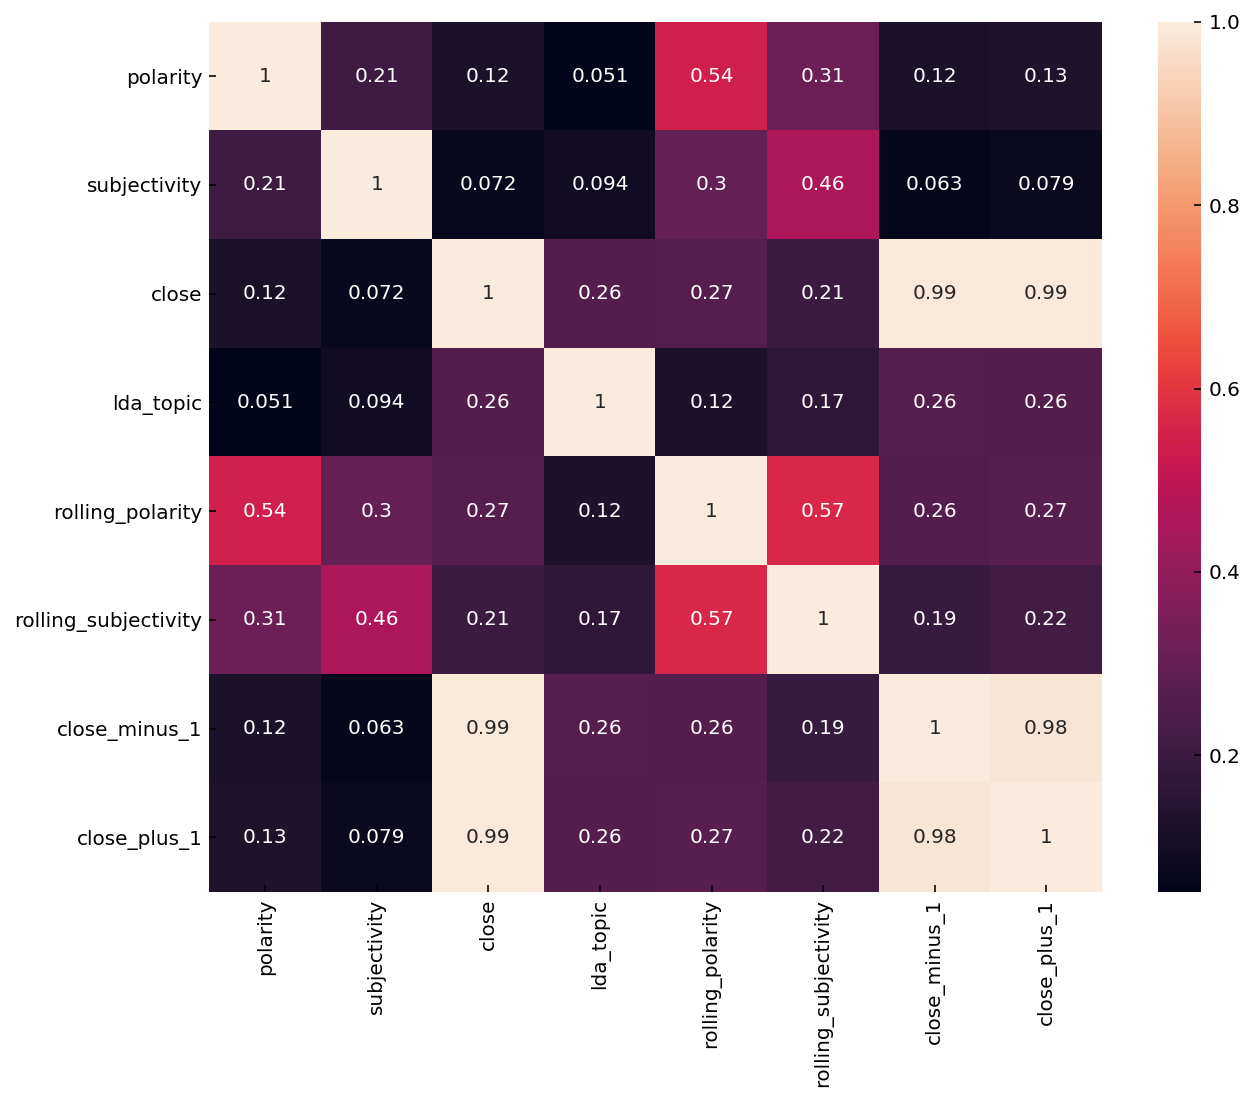

In [249]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(wk_sent_brent.corr(), annot=True, ax=ax)
plt.show()

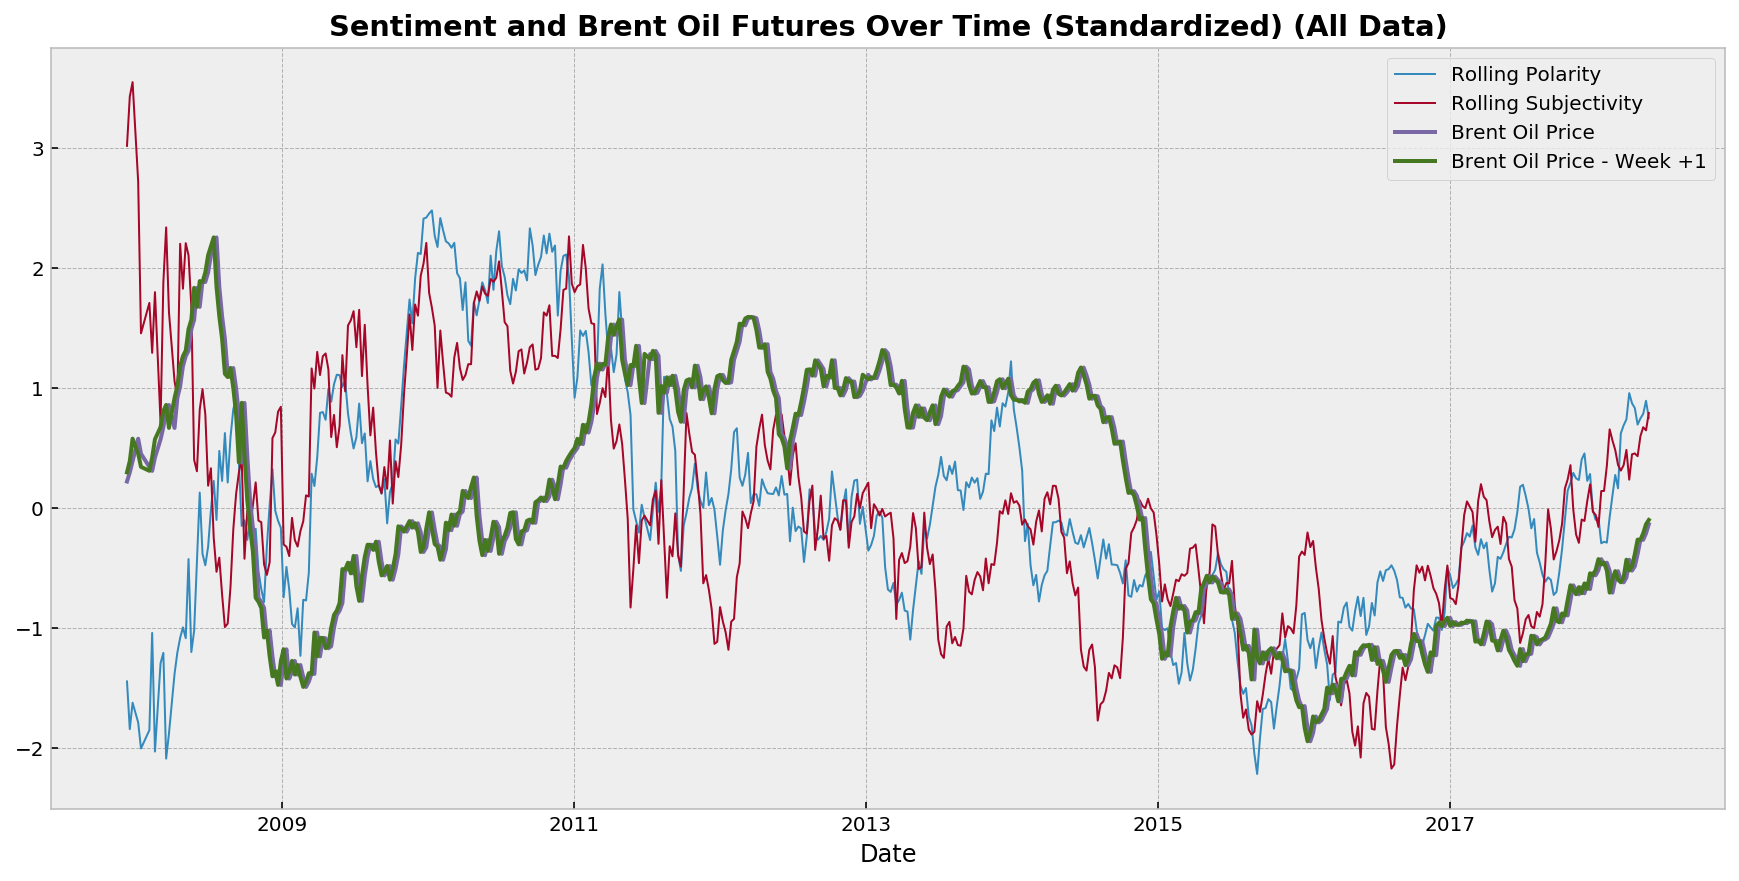

In [258]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.rcParams['lines.linewidth'] = 1
ax.plot(wk_sent_brent.index[10:-1], ss.fit_transform(
    wk_sent_brent['rolling_polarity'][10:-1].values.reshape(-1, 1)), label='Rolling Polarity', lw=1)
ax.plot(wk_sent_brent.index[10:-1], ss.fit_transform(
    wk_sent_brent['rolling_subjectivity'][10:-1].values.reshape(-1, 1)), label='Rolling Subjectivity', lw=1)
ax.plot(wk_sent_brent.index[10:-1], ss.fit_transform(
    wk_sent_brent['close'][10:-1].values.reshape(-1, 1)), label='Brent Oil Price', lw=2)
ax.plot(wk_sent_brent.index[10:-1], ss.fit_transform(
    wk_sent_brent['close_plus_1'][10:-1].values.reshape(-1, 1)), label='Brent Oil Price - Week +1', lw=2)
ax.set_xlabel('Date')
ax.set_title('Sentiment and Brent Oil Futures Over Time (Standardized) (All Data)', fontweight='bold')
ax.legend()
plt.show()

The trend is not very close but seems to be better in the last few years. There are far more articles in the last four years and so it makes sense that the data would fit better.

Therefore, the models will only be trained on the last few years of data.

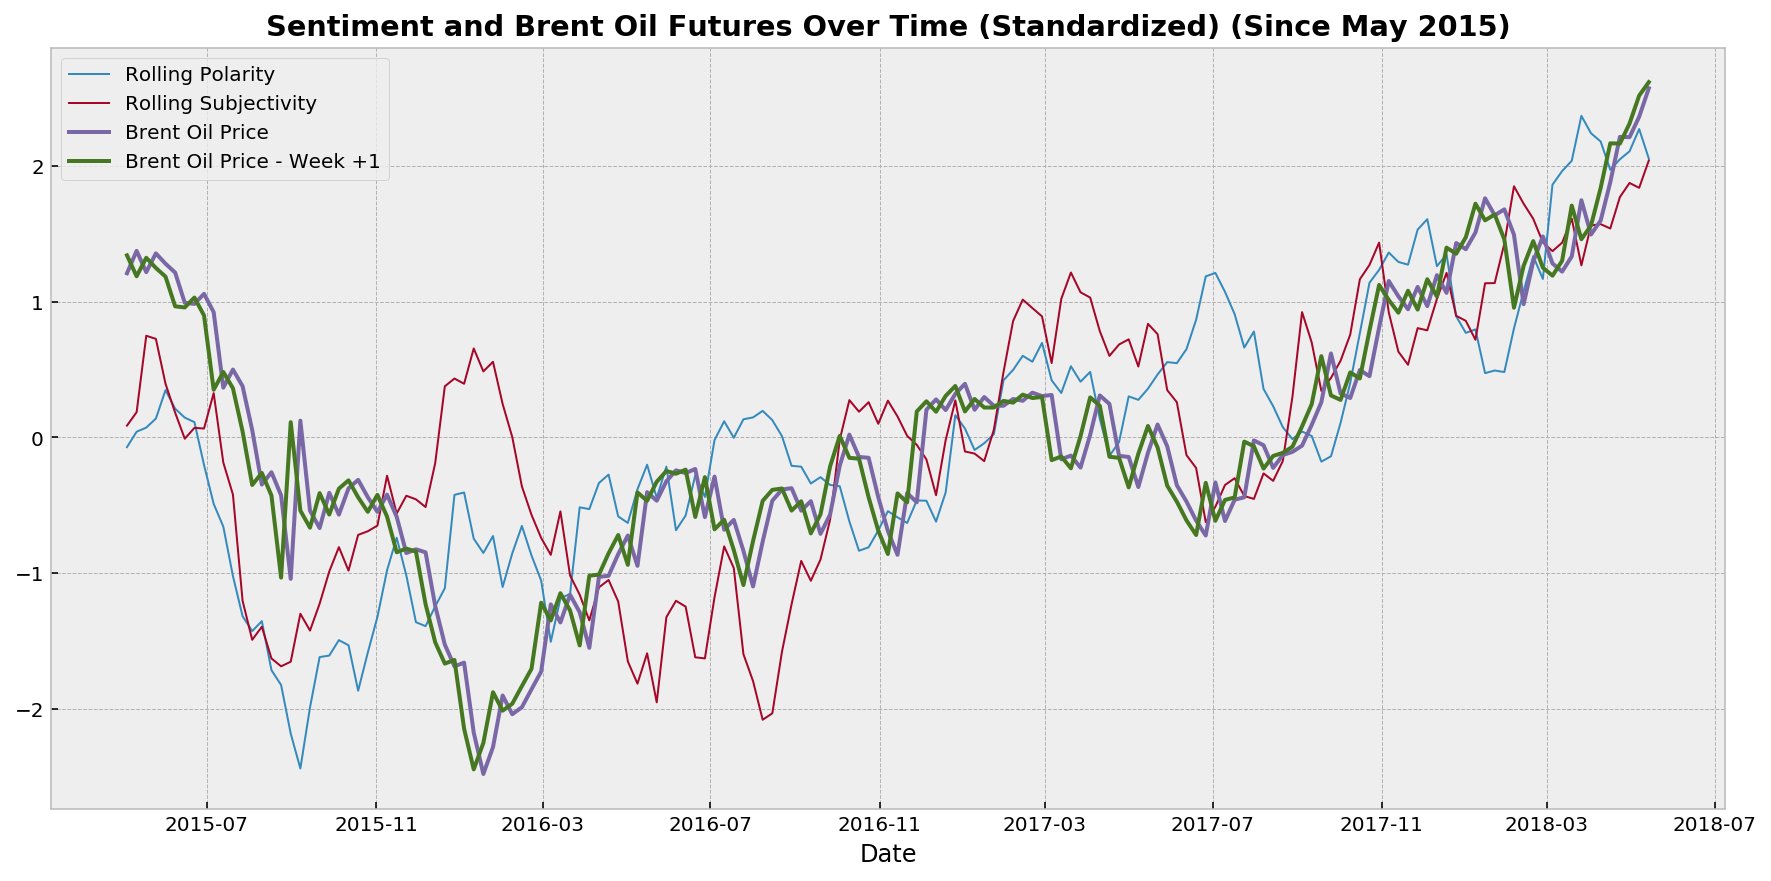

In [257]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(wk_sent_brent.index[-160:-1], ss.fit_transform(
    wk_sent_brent['rolling_polarity'][-160:-1].values.reshape(-1, 1)), label='Rolling Polarity', lw=1)
ax.plot(wk_sent_brent.index[-160:-1], ss.fit_transform(
    wk_sent_brent['rolling_subjectivity'][-160:-1].values.reshape(-1, 1)), label='Rolling Subjectivity', lw=1)
ax.plot(wk_sent_brent.index[-160:-1], ss.fit_transform(
    wk_sent_brent['close'][-160:-1].values.reshape(-1, 1)), label='Brent Oil Price', lw=2)
ax.plot(wk_sent_brent.index[-160:-1], ss.fit_transform(
    wk_sent_brent['close_plus_1'][-160:-1].values.reshape(-1, 1)), label='Brent Oil Price - Week +1', lw=2)
ax.set_xlabel('Date')
ax.set_title('Sentiment and Brent Oil Futures Over Time (Standardized) (Since May 2015)', fontweight='bold')
ax.legend()
plt.show()

The data will will be cut down to only include data after 20-04-2015

In [354]:
energy_articles_masked = pd.read_csv('Data/final_energy_articles_clean.csv')
energy_articles_masked.drop('Unnamed: 0', axis=1, inplace=True)
energy_articles_masked['date'] = pd.to_datetime(energy_articles_masked['date'])
energy_articles_masked['week'] = pd.to_datetime(energy_articles_masked['week'])

In [355]:
mask = energy_articles_masked['date']>datetime(2015, 4, 20)

In [356]:
energy_articles_masked = energy_articles_masked.loc[mask, :]

<a id="sentiment-analysis"></a>

## Sentiment Analysis

All of the stages shown below (Data cleaning, sentiment analysis, LDA, and modelling will be done in the final pipeline. The stages are shown for demonstration.

In [294]:
from textblob import  TextBlob
import textacy

In [154]:
textacy_model = textacy.load_spacy('en_core_web_sm')

In [155]:
def process_text(documents):
    tokenised_texts = []
    texts = []
    pos = ['NOUN', 'ADJ', 'VERB', 'ADV']
    for document in textacy_model.pipe(documents):
        tokens = [token.lemma_.lower() 
                  for token in document 
                  if token.pos_ in pos 
                  and token.is_stop == False
                  and 'say' not in str(token)
                  and 'freestar' not in str(token)
                  and 'googletag' not in str(token)]
        doc_ = ''
        for token in tokens:
            doc_ += str(token) + ' '
        doc_ = textacy.preprocess_text(doc_, lowercase=True, no_urls=True, no_punct=True)
        texts.append(doc_)
        doc_ = textacy.doc.Doc(doc_, lang='en')
        tokenised_texts.append(doc_)
    return texts, tokenised_texts

In [ ]:
contents, tokenised_contents = process_text(energy_articles['content'])

In [23]:
# two functions to get the polarity and subjectivity of a text using textblob
def get_polarity(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

def get_subjectivity(text):
    blob = TextBlob(text)
    return blob.sentiment.subjectivity

These were then mapped onto the cleaned content of the articles.

In [ ]:
energy_articles['clean_content'] = contents

In [ ]:
energy_articles['polarity'] = energy_article['clean_content'].map(get_polarity)

In [ ]:
energy_articles['subjectivity'] = energy_article['clean_content'].map(get_subjectivity)

<a id="lda"></a>

## Topic Modelling - Latent Dirichlet Allocation (LDA)

In [ ]:
from gensim.models.ldamulticore import LdaModel
from gensim import corpora
import pickle

In [ ]:
tokenised_contents_l = [list(x) for x in tokenised_contents]
tokenised_contents_l = [[str(y) for y in x] for x in tokenised_contents_l]

In [ ]:
dictionary = corpora.Dictionary(tokenised_contents_l)
dictionary.compactify()

In [ ]:
corpus = [dictionary.doc2bow(i) for i in tokenised_contents_l]

In [ ]:
%%time
lda_model = LdaModel(corpus,
                     num_topics=100,
                     id2word=dictionary,
                     passes=40)

The fitted model and corpus were pickled and can be loaded below:

In [55]:
with open('Data/corpus.pkl', 'rb') as f:
    corpus = pickle.load(f)

In [56]:
with open('Data/lda_model.pkl', 'rb') as f:
    lda_model = pickle.load(f)

The 100 topics with their keywords are identified below:

All documents were assigned a majority topic.

In [110]:
topics = []
for x in list(lda_model.get_document_topics(corpus)):
    topics.append(x[0][0])

In [156]:
energy_articles['lda_topic'] = topics

In [89]:
topic_keywords = pd.read_csv('Data/clean_topic_keywords.csv')
topic_keywords.drop('Unnamed: 0', axis=1, inplace=True)
topic_keywords

topics
0                                       ['company ', 'claim ', 'case ', 'court ', 'oil ', 'legal ', 'say ', 'pay ', 'law ', 'investigation']
1                          ['restart ', 'bpd ', 'mooring ', 'buoy ', 'turret ', 'reopen ', 'compressor ', 'magnitude ', 'moor ', 'coincide']
2                     ['employer ', 'freeze ', 'labour ', 'collective ', 'dinner ', 'affect ', 'holiday ', 'disappointed ', 'taxi ', 'walk']
3                              ['lay ', 'cable ', 'everyday ', 'telecom ', 'whisky ', 'heater ', '23rd ', '1960 ', 'negotiating ', 'indoor']
4                 ['licence ', 'spud ', 'exploration ', 'prospect ', 'programme ', 'extension ', 'permit ', 'continue ', 'active ', 'month']
5                               ['market ', 'supply ', 'demand ', 'growth ', 'grow ', 'global ', 'chain ', 'world ', 'capacity ', 'country']
6                                  ['contract ', 'work ', 'project ', 'year ', 'service ', 'award ', 'engineering ', 'say ', 'win ', 'deal']
7                                       ['say ', 'company ', 'job ', 'cut ', 'employee ', 'staff ', 'firm ', 'work ', 'cost ', 'contractor']
8                      ['committee ', 'allowance ', 'pattern ', 'urge ', 'salary ', 'bonus ', 'parliament ', 'forecourt ', 'hour ', 'shift']
9                                      ['d ', 'document ', 's ', 'function ', 'tower ', 'true ', 'i ', 'var ', 'municipal ', 'desalination']
10                             ['solar ', 'load ', 'percent ', 'wait ', 'form ', 'panel ', 'grid ', 'cost ', 'startup ', 'newsletterplease']
11                                ['waste ', 'produce ', 'biofuel ', 'light ', 'fuel ', 'green ', 'ethanol ', 'convert ', 'use ', 'process']
12                  ['scholar ', 'partial ', 'hatch ', 'receipt ', 'nomination ', 'examination ', 'render ', 'singer ', 'suspicion ', 'vat']
13                                  ['say ', 'strike ', 'union ', 'worker ', 'member ', 'meeting ', 'pay ', 'talk ', 'action ', 'yesterday']
14                               ['exploration ', 'drill ', 'discovery ', 'oil ', 'block ', 'prospect ', 'say ', 'gas ', 'area ', 'company']
15                               ['tax ', 'investment ', 'government ', 'say ', 'new ', 'cost ', 'revenue ', 'industry ', 'need ', 'fiscal']
16       ['protest ', 'activist ', 'protester ', 'demonstration ', 'loyal ', 'behaviour ', 'people ', 'polar ', 'expression ', 'campaigner']
17                  ['environmental ', 'say ', 'local ', 'plan ', 'site ', 'community ', 'planning ', 'impact ', 'application ', 'proposal']
18             ['chinese ', 'unconventional ', 'noc ', 'korean ', 'kerosene ', 'bed ', 'nerve ', 'factory ', 'memorandum ', 'understanding']
19          ['mill ', 'scandinavian ', 'electro ', 'fraught ', 'induction ', 'redirect ', 'thumb ', 'numerical ', 'federation ', 'radiator']
20                      ['harbour ', 'user ', 'cleantech ', 'quay ', 'wheat ', 'caisson ', 'hectare ', 'donate ', 'grain ', 'encouragement']
21                   ['energy ', 'renewable ', 'tidal ', 'technology ', 'electricity ', 'target ', 'resource ', 'power ', 'sector ', 'wave']
22                ['performance ', 'improvement ', 'management ', 'non ', 'point ', 'assess ', 'measure ', 'implement ', 'audit ', 'relate']
23                              ['fund ', 'bank ', 'debt ', 'company ', 'equity ', 'financial ', 'capital ', 'cash ', 'finance ', 'private']
24                        ['datum ', 'survey ', 'seismic ', 'study ', '3d ', 'analysis ', 'identify ', 'information ', 'acquire ', 'result']
25                       ['power ', 'electricity ', 'generation ', 'grid ', 'plant ', 'capacity ', 'say ', 'system ', 'instal ', 'megawatt']
26                        ['delay ', 'weather ', 'condition ', 'storm ', 'wave ', 'hit ', 'supplementary ', 'window ', 'high ', 'withstand']
27            ['security ', 'attack ', 'threat ', 'aviation ', 'symptom ', 'satisfied ', 'applicable ', 'rewarding ', 'hostage ', 'protect']
28                 ['rare ', 'sediment ', 'we

<a id="group-data"></a>

## Group Data by Week

Week column was created using the code below to give the Monday of each week.

```python
energy_articles['week'] = energy_articles.date.map(lambda x:
                                                   int(str(x.year) + str(x.weekofyear)) 
                                                   if len(str(x.weekofyear)) == 2
                                                   else int(str(x.year) + str(0) + str(x.weekofyear)))
energy_articles['week'] = energy_articles.week.map(
    lambda x: datetime.strptime(str(x) + '-1', "%Y%W-%w"))

brent_oil_price['week'] = brent_oil_price.date.map(lambda x:
                                                   int(str(x.year) + str(x.weekofyear)) 
                                                   if len(str(x.weekofyear)) == 2
                                                   else int(str(x.year) + str(0) + str(x.weekofyear)))
brent_oil_price['week'] = brent_oil_price.week.map(
    lambda x: datetime.strptime(str(x) + '-1', "%Y%W-%w"))
```

In [153]:
energy_articles = pd.read_csv('Data/final_energy_articles_masked.csv')
brent_oil_price = pd.read_csv('Data/brent_crude_oil_price_clean.csv')
energy_articles.drop('Unnamed: 0', axis=1, inplace=True)
brent_oil_price.drop('Unnamed: 0', axis=1, inplace=True)
energy_articles['date'] = pd.to_datetime(energy_articles['date'])
energy_articles['week'] = pd.to_datetime(energy_articles['week'])
brent_oil_price['date'] = pd.to_datetime(brent_oil_price['date'])
brent_oil_price['week'] = pd.to_datetime(brent_oil_price['week'])

time: 741 ms


In [154]:
wk_closing_brent_price = brent_oil_price.groupby('week')[['close']].first()

time: 8.28 ms


In [155]:
wk_sentiment_all = energy_articles.groupby('week')[['polarity', 'subjectivity']].mean()

time: 6.13 ms


In [156]:
# get the major lda topic by getting the mode of the lda topics for each week
wk_maj_lda_topic = energy_articles.groupby('week')[['lda_topic']].agg(lambda x: str(stats.mode(x)[0][0]))

time: 65 ms


In [157]:
wk_sent_brent = wk_sentiment_all.join(wk_closing_brent_price, how='outer')
wk_sent_brent = wk_sent_brent.join(wk_maj_lda_topic, how='outer')
wk_sent_brent.dropna(inplace=True)

time: 14.9 ms


In [158]:
# get the rolling polarity and subjectivity to smooth the data
wk_sent_brent['rolling_polarity'] = wk_sent_brent['polarity'].rolling(window=10).mean()
wk_sent_brent['rolling_subjectivity'] = wk_sent_brent['subjectivity'].rolling(window=10).mean()

time: 6.65 ms


In [42]:
wk_sent_brent['close_minus_1'] = wk_sent_brent['close'].shift()
wk_sent_brent['close_plus_1'] = wk_sent_brent['close'].shift(-1)

In [159]:
wk_sent_brent.dropna(inplace=True)

time: 3.46 ms


In [161]:
len(wk_sent_brent)

152

time: 3.47 ms


In [160]:
wk_sent_brent.head(15)

polarity  subjectivity  close lda_topic  rolling_polarity  \
week                                                                    
2015-06-29  0.036970      0.437637  63.34         0          0.048627   
2015-07-06  0.034602      0.466270  62.01         0          0.046166   
2015-07-13  0.034737      0.444262  56.54         0          0.044674   
2015-07-20  0.028369      0.455018  57.85         0          0.041442   
2015-07-27  0.027347      0.423706  56.65         0          0.038811   
2015-08-03  0.044641      0.438004  53.47         7          0.037837   
2015-08-10  0.039232      0.439802  49.52         6          0.038486   
2015-08-17  0.017516      0.442380  50.41         0          0.035279   
2015-08-24  0.037576      0.437316  48.74         0          0.034310   
2015-08-31  0.010257      0.435148  42.69         5          0.031125   
2015-09-07  0.014150      0.464872  54.15         5          0.028843   
2015-09-14  0.074525      0.456717  47.63         5          0.032835   
2015-09-21  0.067746      0.459511  46.37         0          0.036136   
2015-09-28  0.029361      0.473306  48.92         0          0.036235   
2015-10-05  0.037448      0.437546  47.34         0          0.037245   

            rolling_subjectivity  
week                              
2015-06-29              0.455883  
2015-07-06              0.457207  
2015-07-13              0.453264  
2015-07-20              0.451443  
2015-07-27              0.445416  
2015-08-03              0.443197  
2015-08-10              0.443939  
2015-08-17              0.442139  
2015-08-24              0.441693  
2015-08-31              0.441954  
2015-09-07              0.444678  
2015-09-14              0.443723  
2015-09-21              0.445247  
2015-09-28              0.447076  
2015-10-05              0.448460

time: 18 ms


Predictions will be made on the close_plus_1 column as the target to predict the oil price for the following week.

<a id="models"></a>

## Statistical Models

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

In [46]:
X = wk_sent_brent.iloc[:, [3, 4, 5]].copy()
y = wk_sent_brent['close_plus_1'].copy()

In [47]:
len(X)

151

In [48]:
len(y)

151

In [49]:
X.head()

lda_topic  rolling_polarity  rolling_subjectivity
week                                                        
2015-06-29         0          0.048627              0.455883
2015-07-06         0          0.046166              0.457207
2015-07-13         0          0.044674              0.453264
2015-07-20         0          0.041442              0.451443
2015-07-27         0          0.038811              0.445416

In [50]:
X['lda_topic'] = X['lda_topic'].map(lambda x: str(x))

In [51]:
X = pd.get_dummies(X, drop_first=True)


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)

In [53]:
ss = StandardScaler()
lr = LinearRegression()
rf = RandomForestRegressor()
nnet = MLPRegressor(max_iter=10000)

<a id="linear"></a>

### Linear Regression

In [468]:
lr_pipe = Pipeline([('scaler', ss),
                   ('linear', lr)])

In [469]:
cross_val_score(lr_pipe, X_train, y_train, cv=5)

array([0.52189134, 0.39906148, 0.50846717, 0.30459308, 0.15457931])

In [470]:
lin_reg = lr_pipe.fit(X_train, y_train)

In [471]:
lin_reg.score(X_train, y_train)

0.5273422515367352

In [472]:
lin_reg.score(X_test, y_test)

0.5716201544818409

In [473]:
lin_reg.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [474]:
lin_reg.score(X, y)

0.5486819776538905

In [475]:
pd.DataFrame({'Feature': X.columns, 'Coefficients': lin_reg.steps[1][1].coef_})

Feature  Coefficients
0      rolling_polarity      5.203170
1  rolling_subjectivity      2.617708
2           lda_topic_4     -0.801156
3           lda_topic_5      0.234904
4           lda_topic_6     -0.105008
5           lda_topic_7      0.010818

<a id="random-forest"></a>

### Random Forest

In [54]:
rf_pipe = Pipeline([('scaler', ss),
                    ('forest', rf)])

In [55]:
rf_params = {
    'forest__n_estimators': [5, 10, 15, 20, 30, 40, 50, 60, 80, 100],
    'forest__max_features': ['auto', 'sqrt'],
    'forest__max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,20,21,22,23,24,25,30, None]
}

In [56]:
forest_gs = GridSearchCV(rf_pipe, rf_params, n_jobs=-1, cv=5, verbose=1)
forest_gs.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 1480 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:   48.1s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('forest', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_...imators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'forest__n_estimators': [5, 10, 15, 20, 30, 40, 50, 60, 80, 100], 'forest__max_features': ['auto', 'sqrt'], 'forest__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25, 30, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [57]:
forest_gs.best_score_

0.6778216458219763

In [58]:
forest_gs.best_params_

{'forest__max_depth': 3,
 'forest__max_features': 'auto',
 'forest__n_estimators': 40}

In [59]:
forest_gs.score(X_test, y_test)

0.6441537642900677

In [60]:
forest_best = forest_gs.best_estimator_

In [61]:
forest_best.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('forest', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])

In [62]:
forest_best.score(X, y)

0.7964259957706341

In [63]:
pd.DataFrame({'Feature': X.columns, 'Feature Importance': forest_best.steps[1][1].feature_importances_})

Feature  Feature Importance
0      rolling_polarity            0.351682
1  rolling_subjectivity            0.644771
2           lda_topic_4            0.001901
3           lda_topic_5            0.000559
4           lda_topic_6            0.001087
5           lda_topic_7            0.000000

<a id="neural-network"></a>

### Neural Network

In [124]:
len(X_train)

127

In [125]:
127/(2*(12))

5.291666666666667

In [127]:
nnet_params = {
    'nnet__hidden_layer_sizes': [(6,6,6,6,6,6)],
    'nnet__activation': ['identity', 'relu'],
    'nnet__solver': ['lbfgs', 'adam'],
    'nnet__alpha': [0.001, 0.01, 0.1, 1., 10.],
    'nnet__learning_rate_init': [0.001, 0.01, 0.1]   
}

In [130]:
nnet_pipe = Pipeline([('scaler', ss),
                      ('nnet', nnet)])

In [132]:
nnet_gs = GridSearchCV(nnet_pipe, nnet_params, n_jobs=-1, cv=5, verbose=1)
nnet_gs.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 127 tasks      | elapsed:    8.5s
/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  1.1min
/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('nnet', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rat...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'nnet__hidden_layer_sizes': [(6, 6, 6, 6, 6, 6)], 'nnet__activation': ['identity', 'relu'], 'nnet__solver': ['lbfgs', 'adam'], 'nnet__alpha': [0.001, 0.01, 0.1, 1.0, 10.0], 'nnet__learning_rate_init': [0.001, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [133]:
nnet_gs.best_score_

0.5916239093456147

In [134]:
nnet_gs.best_params_

{'nnet__activation': 'relu',
 'nnet__alpha': 0.1,
 'nnet__hidden_layer_sizes': (6, 6, 6, 6, 6, 6),
 'nnet__learning_rate_init': 0.001,
 'nnet__solver': 'adam'}

In [135]:
nnet_gs.score(X_test, y_test)

0.5115096419287679

In [136]:
nnet_best = nnet_gs.best_estimator_

In [137]:
nnet_best.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('nnet', MLPRegressor(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(6, 6, 6, 6, 6, 6), learning_rate='constant',
       lea...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))])

In [138]:
nnet_best.score(X, y)

0.658908003574884

<a id="pipeline"></a>

### Complete Pipeline

In [21]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
import textacy
import pickle
from gensim.models.ldamulticore import LdaModel
from gensim import corpora
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from textblob import TextBlob

time: 2.74 s


In [22]:
class energy_articles_preprocessor(BaseEstimator, TransformerMixin):

    def fit(self, X, y):
        return self

    def transform(self, X):
        X = X.loc[:, ['date', 'content']]
        X['date'] = pd.to_datetime(X['date'])
        X['week'] = X.date.map(lambda x:
                                 int(str(x.year) + str(x.weekofyear))
                                 if len(str(x.weekofyear)) == 2
                                 else int(str(x.year) + str(0) + str(x.weekofyear)))
        X['week'] = X.week.map(
            lambda x: datetime.strptime(str(x) + '-1', "%Y%W-%w"))
        return X

time: 14.1 ms


In [23]:
class article_cleaner(BaseEstimator, TransformerMixin):

    
    def fit(self, X, y):
        return self
        
    def transform(self, X):
        
        textacy_model = textacy.load_spacy('en_core_web_sm')
        
        def process_text(documents):
            tokenised_texts = []
            texts = []
            pos = ['NOUN', 'ADJ', 'VERB', 'ADV']
            for document in textacy_model.pipe(documents):
                tokens = [token.lemma_.lower() 
                          for token in document 
                          if token.pos_ in pos 
                          and token.is_stop == False
                          and 'say' not in str(token)
                          and 'freestar' not in str(token)
                          and 'googletag' not in str(token)]
                doc_ = ''
                for token in tokens:
                    doc_ += str(token) + ' '
                doc_ = textacy.preprocess_text(doc_, lowercase=True, no_urls=True, no_punct=True)
                texts.append(doc_)
                doc_ = textacy.doc.Doc(doc_, lang='en')
                tokenised_texts.append(doc_)
            return texts, tokenised_texts
        
        contents, tokenised_contents = process_text(X['content'])
        X['clean_content'] = contents
        tokenised_contents_l = [list(x) for x in tokenised_contents]
        tokenised_contents_l = [[str(y) for y in x] for x in tokenised_contents_l]
        X['tokenised_content'] = tokenised_contents_l
        return X

time: 44.1 ms


In [24]:
class topic_modelling(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y):
        return self
        
    def transform(self, X):
                
        with open('Data/lda_model.pkl', 'rb') as f:
            lda_model = pickle.load(f)
        
        dictionary = corpora.Dictionary(X['tokenised_content'])
        dictionary.compactify()
        corpus = [dictionary.doc2bow(i) for i in X['tokenised_content']]
        topics = [t[0][0] for t in list(lda_model.get_document_topics(corpus))]
        X['lda_topic'] = topics
        return X

time: 11.7 ms


In [25]:
class energy_sentiment_analysis(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y):
        return self
        
    def transform(self, X):
        def get_polarity(text):
            blob = TextBlob(text)
            return blob.sentiment.polarity

        def get_subjectivity(text):
            blob = TextBlob(text)
            return blob.sentiment.subjectivity
        
        X['polarity'] = X['clean_content'].map(get_polarity)
        X['subjectivity'] = X['clean_content'].map(get_subjectivity)
        
        return X

time: 13 ms


In [26]:
class groupby_week(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y):
        return self
        
    def transform(self, X):
        X = X.groupby('week')[['polarity', 'subjectivity']].mean()
        X['rolling_polarity'] = X['polarity'].rolling(window=10).mean()
        X['rolling_subjectivity'] = X['subjectivity'].rolling(window=10).mean()
        X.drop(['polarity', 'subjectivity'], axis=1, inplace=True)
        X.dropna(inplace=True)
        X.reset_index(drop=True, inplace=True)
        return X

time: 11.9 ms


In [27]:
class create_target():
    
    def transform(self, X, y):
        X = X.groupby('week')[['polarity', 'subjectivity']].mean()
        X['rolling_polarity'] = X['polarity'].rolling(window=10).mean()
        X['rolling_subjectivity'] = X['subjectivity'].rolling(window=10).mean()
        X.drop(['polarity', 'subjectivity'], axis=1, inplace=True)
        X.dropna(inplace=True)
        y['week'] = y.index.map(lambda x:
                                 int(str(x.year) + str(x.weekofyear))
                                 if len(str(x.weekofyear)) == 2
                                 else int(str(x.year) + str(0) + str(x.weekofyear)))
        y['week'] = y.week.map(
            lambda x: datetime.strptime(str(x) + '-1', "%Y%W-%w"))
        y = y.groupby('week')[['Settle']].first()
        joined = X.join(y, how='outer')
        joined.dropna(inplace=True)
        X = joined.drop(['Settle'], axis=1)
        y = np.array(joined['Settle'])
        X = pd.get_dummies(X, drop_first=True)
        X.reset_index(drop=True, inplace=True)
        return y

time: 32.8 ms


In [28]:
preprocess = energy_articles_preprocessor()
cleaner = article_cleaner()
lda = topic_modelling()
sent = energy_sentiment_analysis()
group = groupby_week()
target = create_target()
ss = StandardScaler()
rf = RandomForestRegressor(max_depth=3, max_features='auto', n_estimators=20)

time: 6.96 ms


In [29]:
# topic modelling (LDA) not included in this case because topics were found to not have a major impact. 
# I am working on engineering the topics such that they can be used
oil_price_predictor = Pipeline([('preproc', preprocess),
                                ('clean', cleaner),
                                ('sentiment_analysis', sent),
                                ('weekly', group),
                                ('scaler', ss),
                                ('forest', rf)])

time: 3.52 ms


In [30]:
energy_articles = pd.read_csv('Data/final_energy_articles_masked.csv')
brent_oil_price = quandl.get('CHRIS/ICE_B1')

time: 3.68 s


In [31]:
brent_oil_price.head()

Open   High    Low  Settle  Change  Wave  Volume  \
Date                                                            
1993-03-17  18.80  18.80  18.80   18.80     NaN   NaN     0.0   
1993-03-18  18.87  18.87  18.87   18.87     NaN   NaN     0.0   
1993-03-19  18.89  18.89  18.89   18.89     NaN   NaN     0.0   
1993-03-22  18.50  18.50  18.50   18.50     NaN   NaN     0.0   
1993-03-23  18.61  18.61  18.61   18.61     NaN   NaN     0.0   

            Prev. Day Open Interest  EFP Volume  EFS Volume  Block Volume  
Date                                                                       
1993-03-17                      0.0         NaN         NaN           NaN  
1993-03-18                      0.0         NaN         NaN           NaN  
1993-03-19                      0.0         NaN         NaN           NaN  
1993-03-22                      0.0         NaN         NaN           NaN  
1993-03-23                      0.0         NaN         NaN           NaN

time: 20 ms


In [32]:
actual_y  = target.transform(energy_articles, brent_oil_price)

time: 165 ms


In [203]:
oil_price_model_fitted = oil_price_predictor.fit(energy_articles, actual_y)

time: 47min 14s


In [204]:
preds = oil_price_model_fitted.predict(energy_articles)

time: 32min 34s


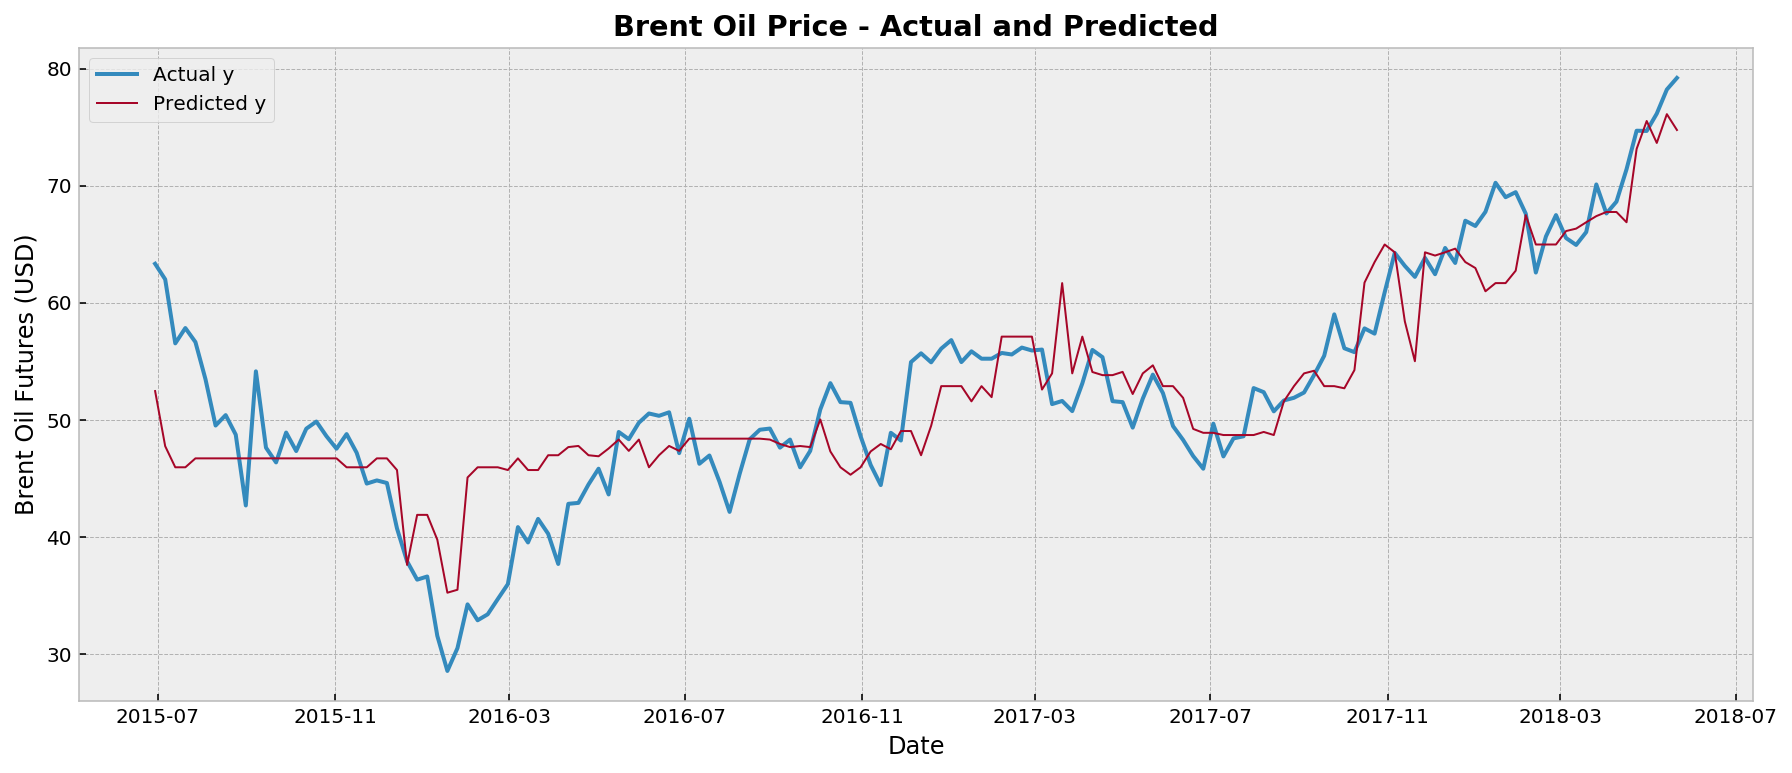

time: 850 ms


In [205]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(wk_sent_brent.index, actual_y, label='Actual y')
ax.plot(wk_sent_brent.index, preds, lw=1, label='Predicted y')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Brent Oil Futures (USD)')
ax.set_title('Brent Oil Price - Actual and Predicted', fontweight='bold')
plt.savefig('/Users/angusfranz/Desktop/oil_price_predict3.jpg', dpi=300)
plt.show()

In [163]:
# with open('Data/oil_price_predictor.pkl', 'wb') as f:
#     pickle.dump(oil_price_model_fitted, f)

time: 7.61 ms


In [19]:
# load my pre fitted model
with open('Data/oil_price_predictor.pkl', 'rb') as f:
    oil_price_predictor = pickle.load(f)

<a id="test-pipeline"></a>

#### Test Pipeline to Predict Next Weeks Oil Price

In [176]:
energy_articles_test = scrape_energy_voice_articles(35)

Scraping Energy Voice articles: 100%|██████████| 1386/1386 [28:12<00:00,  1.22s/it]

time: 29min 32s


In [178]:
energy_articles_test = energy_articles_test.iloc[12:, :].copy()

time: 17.1 ms


In [206]:
energy_articles_test.head()

url  \
12                               https://www.energyvoice.com/oilandgas/176150/fears-surface-about-oil-spike-above-150/   
13             https://www.energyvoice.com/oilandgas/north-sea/176151/spirit-energy-to-take-over-babbage-operatorship/   
14              https://www.energyvoice.com/oilandgas/north-sea/176148/prosafe-gets-25m-plus-gig-for-safe-scandinavia/   
15                  https://www.energyvoice.com/oilandgas/north-sea/176145/tory-party-backer-increases-stake-in-cluff/   
16  https://www.energyvoice.com/oilandgas/north-sea/176034/exclusive-serica-energy-announces-aberdeen-office-location/   

                                                          title       date  \
12                     Fears surface about oil spike above $150 2018-07-06   
13              Spirit Energy to take over Babbage operatorship 2018-07-06   
14              Prosafe gets $25m-plus gig for Safe Scandinavia 2018-07-06   
15                   Tory Party backer increases stake in Cluff 2018-07-06   
16  Exclusive: Serica Energy announces Aberdeen office location 2018-07-06   

                                                                                                                                                                                                    content  
12  Oil investors may regret urging companies to cough up cash now instead of investing in growth for later as the dearth of exploration is setting the stage for an unprecedented crude price spike, ac...  
13  Spirit Energy has agreed to take over as operator of the Babbage field and the nearby Cobra discovery in the North Sea. The transfer depends on current operator Premier Oil’s ability to complete t...  
14  Vessel contractor Prosafe will get paid at least $25.5 million for deploying the Safe Scandinavia floatel at the Ula platform in the Norwegian North Sea. The value of the deal with Aker BP could r...  
15  Entrepreneur and philanthropist Michael Spencer has increase his stake in North Sea oil firm Cluff Natural Resources. Mr Spence, a multi-millionaire backer of the Conservative Party, now holds 54....  
16  Oil firm Serica Energy has revealed that it will move into the H1 building at the Hill of Rubislaw complex in Aberdeen next month. Serica has signed a five year lease, with extension options, for ...

time: 76.1 ms


In [207]:
predictions = oil_price_predictor.predict(energy_articles_test)

time: 2min 27s


In [209]:
predictions

array([67.76533005, 75.24795122, 76.15784286, 76.15784286, 76.15784286,
       76.15784286, 76.15784286, 76.15784286, 76.15784286, 76.15784286])

time: 6.99 ms


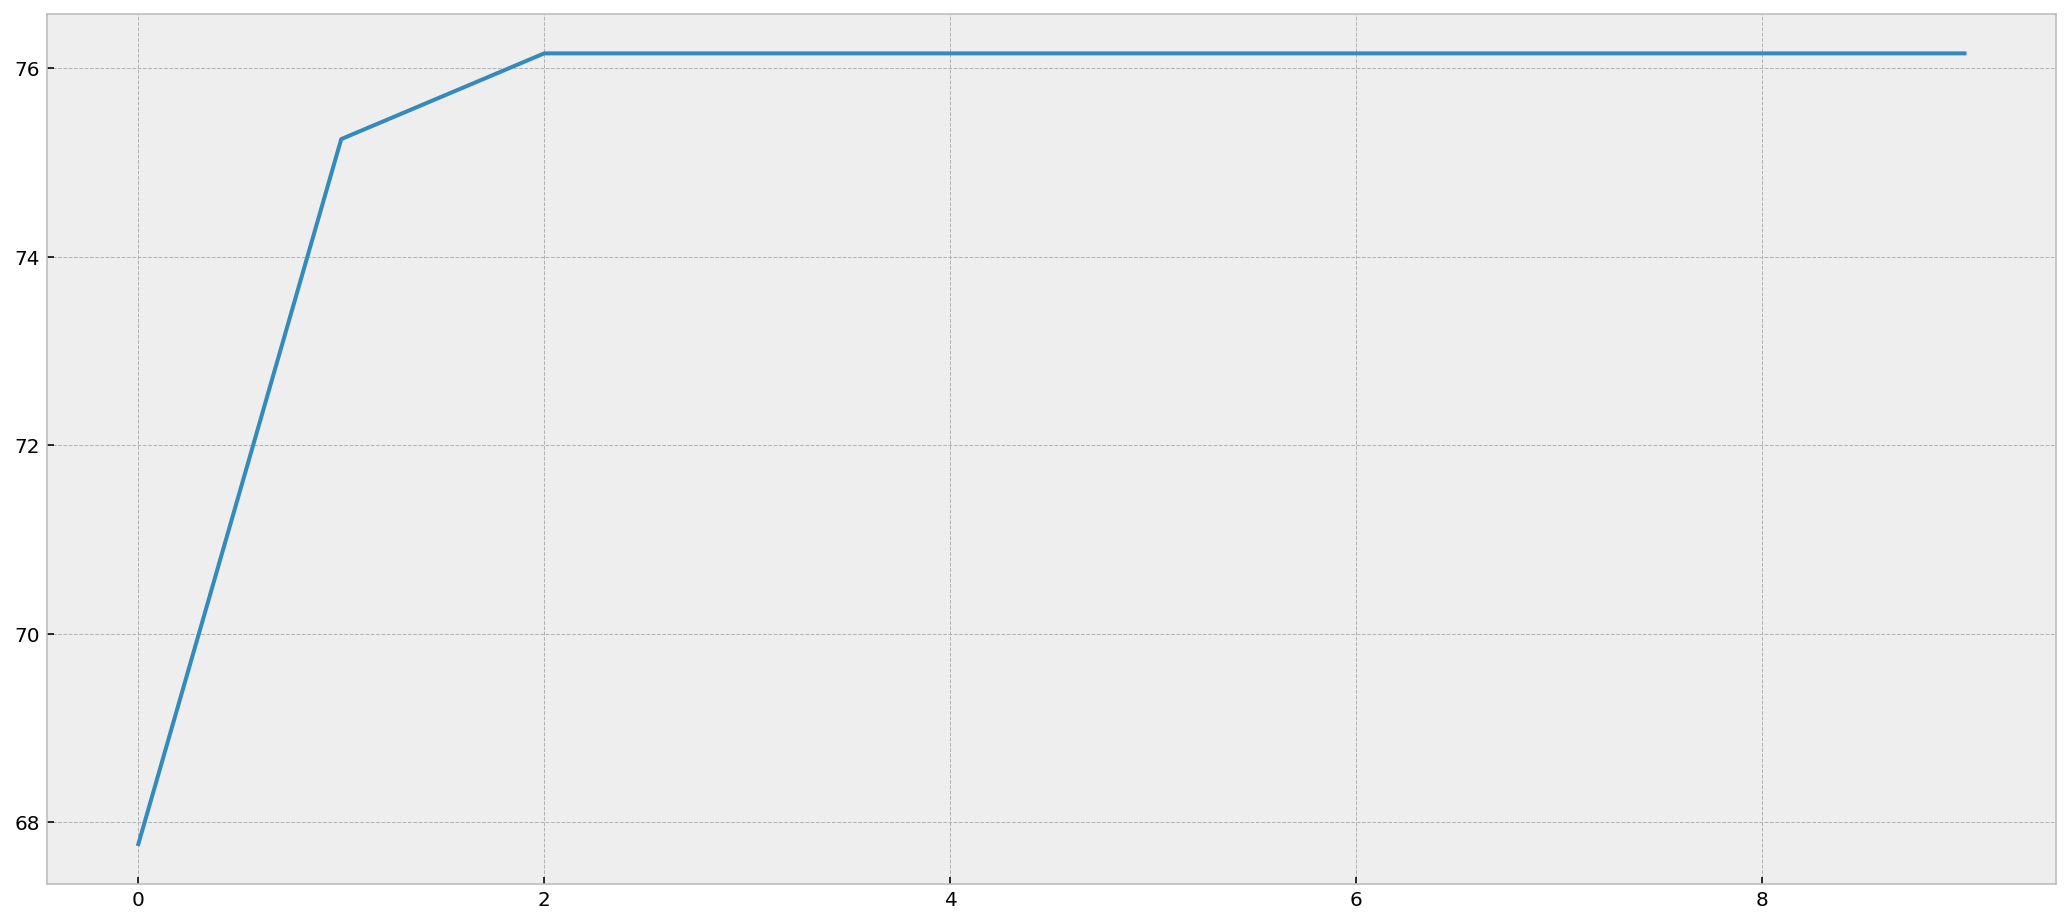

time: 362 ms


In [208]:
fig, ax = plt.subplots(figsize=(18,8))
ax.plot(predictions)
plt.show()

<a id="evaluation"></a>

## Model Evaluation

<a id="lda-eval"></a>

### LDA Evaluation

In [35]:
final_df = pd.read_csv('Data/final_energy_articles_masked.csv')

time: 785 ms


In [36]:
final_df.head(1)

Unnamed: 0  \
0           0   

                                                                                                                     url  \
0  https://www.greentechmedia.com/articles/read/electric-cars-could-save-uber-and-lyft-drivers-5200-a-year#disqus_thread   

                                                         title        date  \
0  Electric Cars Could Save Ride-Sharing Drivers $5,200 a Year  2018-04-02   

                                                                                                                                                                                                   content  \
0  Lyft, Uber and Ride Austin drivers are ideal candidates for electric vehicles, according to a Rocky Mountain Institute analysis.Electric Cars Could Save Ride-Sharing Drivers $5,200 a YearThe rapid...   

      category news_source  lda_topic  \
0  fossil_fuel         gtm          6   

                                                                                                                                                                                             clean_content  \
0  driver ideal candidate electric vehicle accord analysis could save share yearthe rapid growth transportation network company tnc create unique opportunity vehicle electrification benefit city driv...   

   polarity  subjectivity        week  
0   0.10726      0.501787  2018-04-02

time: 21.8 ms


In [37]:
from wordcloud import WordCloud
from PIL import Image

time: 37.6 ms


In [41]:
mask_shape = np.array(Image.open("Data/Images/circle.png"))

time: 55.8 ms


In [42]:
strings0 = ''
for top, cont in zip(final_df['lda_topic'], final_df['clean_content']):
    if top==0:
        strings0 += cont
strings0 = strings0.replace('say', '').replace('oil', '').replace('year', '').replace('ga', '')

time: 91.7 ms


In [43]:
wc0 = WordCloud(background_color='white', collocations=False, 
                mask=mask_shape, width=3000, height=1500).generate(strings0)

time: 5.24 s


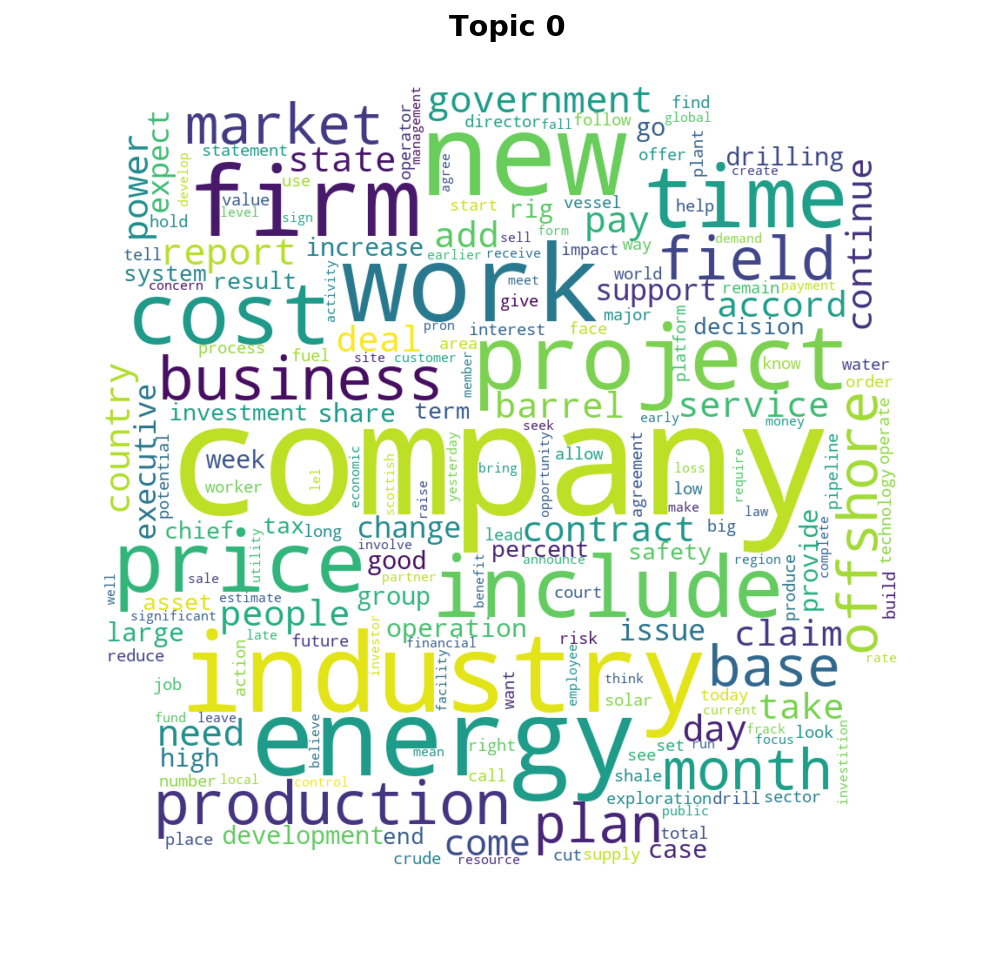

In [210]:
fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(wc0, interpolation='bilinear')
ax.axis("off")
ax.set_title('Topic 0', fontweight='bold')
plt.show()

In [182]:
strings5 = ''
for top, cont in zip(final_df['lda_topic'], final_df['clean_content']):
    if top==5:
        strings5 += cont
strings5 = strings5.replace('say', '').replace('oil', '').replace('year', '').replace('company', '').replace('ga', '')

In [183]:
wc5 = WordCloud(background_color='white', collocations=False, 
                mask=mask_shape, width=3000, height=1500).generate(strings5)

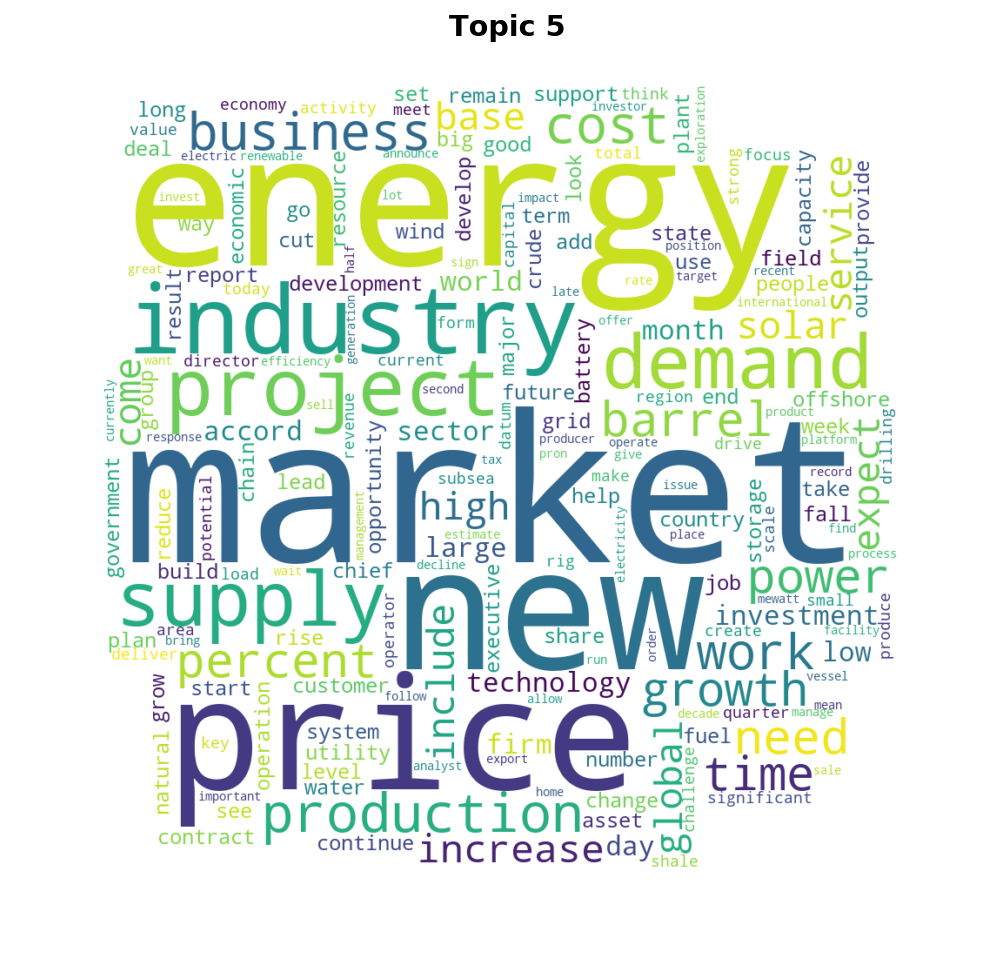

In [199]:
fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(wc5, interpolation='bilinear')
ax.axis("off")
ax.set_title('Topic 5', fontweight='bold')
plt.show()

In [185]:
strings6 = ''
for top, cont in zip(final_df['lda_topic'], final_df['clean_content']):
    if top==6:
        strings6 += cont
strings6 = strings6.replace('say', '').replace('oil', '').replace('year', '').replace('company', '').replace('ga', '')

In [186]:
wc6 = WordCloud(background_color='white', collocations=False, 
                mask=mask_shape, width=3000, height=1500).generate(strings6)

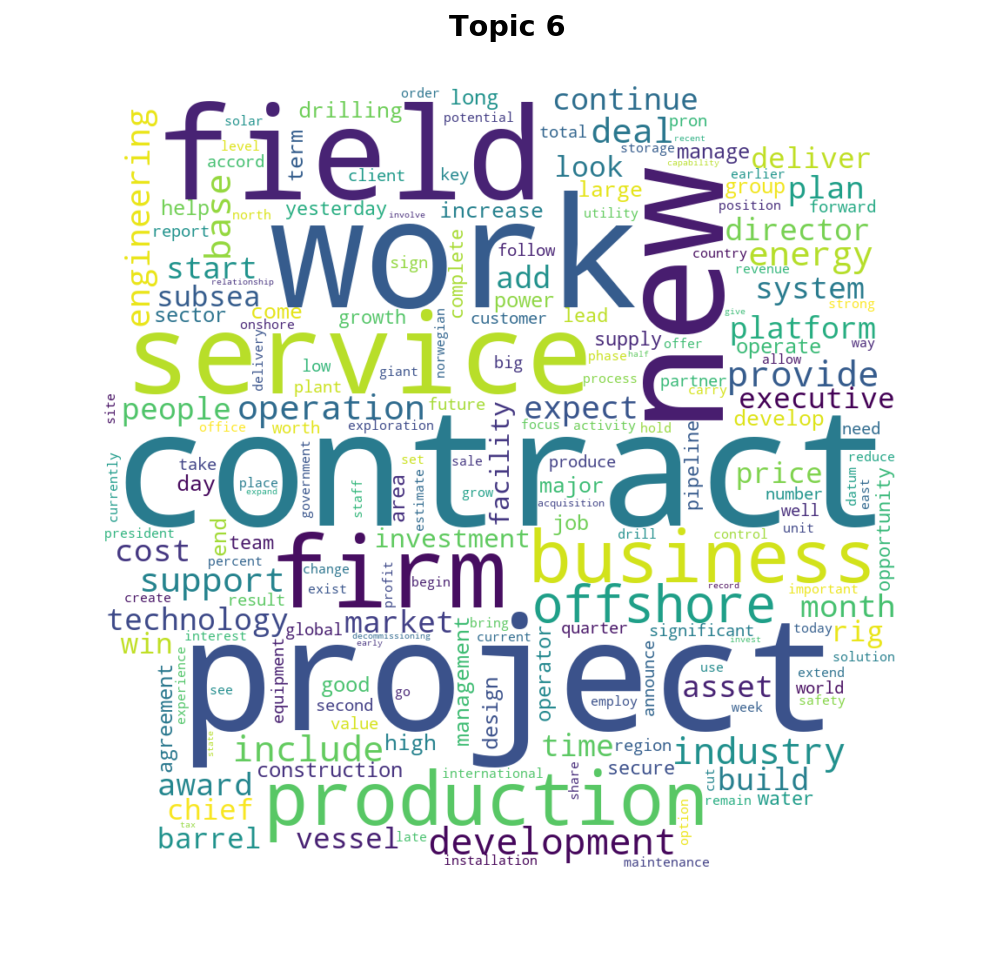

In [200]:
fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(wc6, interpolation='bilinear')
ax.axis("off")
ax.set_title('Topic 6', fontweight='bold')
plt.show()

In [44]:
contents_16 = []
for top, cont in zip(final_df['lda_topic'], final_df['content']):
    if top==16:
        contents_16.append(cont)

time: 25.4 ms


In [45]:
contents_16_df = pd.DataFrame({'content': contents_16})

time: 5.43 ms


In [46]:
contents_16_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 1 columns):
content    36 non-null object
dtypes: object(1)
memory usage: 368.0+ bytes
time: 9.61 ms


In [48]:
contents_16_df.head()

content
0  Things are looking up for Libya oil traders. The North African country where militants disrupted oil production for months just a year ago is now closing in on Saudi Arabia as the third-biggest so...
1  The impact of the energy sector’s drive to become more efficient will be fully revealed at a major conference this week. Deidre Michie, chief executive of industry body Oil and Gas UK (OGUK), is t...
2  Fashion designer Dame Vivienne Westwood turned model in an anti-fracking protest against multinational chemical company Ineos. She was snapped alongside models and activists on Thursday at the #IN...
3  Oil traded above $61 a barrel as signs of slowing U.S. drilling added to optimism that the global crude surplus is abating. Futures were little changed in New York following a 1.7 percent increase...
4  The major economic issues of the 21st century will be the focus on a conference being held at Aberdeen University next week. Leading experts on economics, politics and social sciences will gather ...

time: 7.96 ms


In [49]:
strings16 = ''
for top, cont in zip(final_df['lda_topic'], final_df['clean_content']):
    if top==16:
        strings16 += cont
strings16 = strings16.replace('say', '').replace('oil', '').replace('year', '').replace('company', '').replace('ga', '')

time: 14.6 ms


In [50]:
wc16 = WordCloud(background_color='white', collocations=False, 
                mask=mask_shape, width=3000, height=1500).generate(strings16)

time: 6.08 s


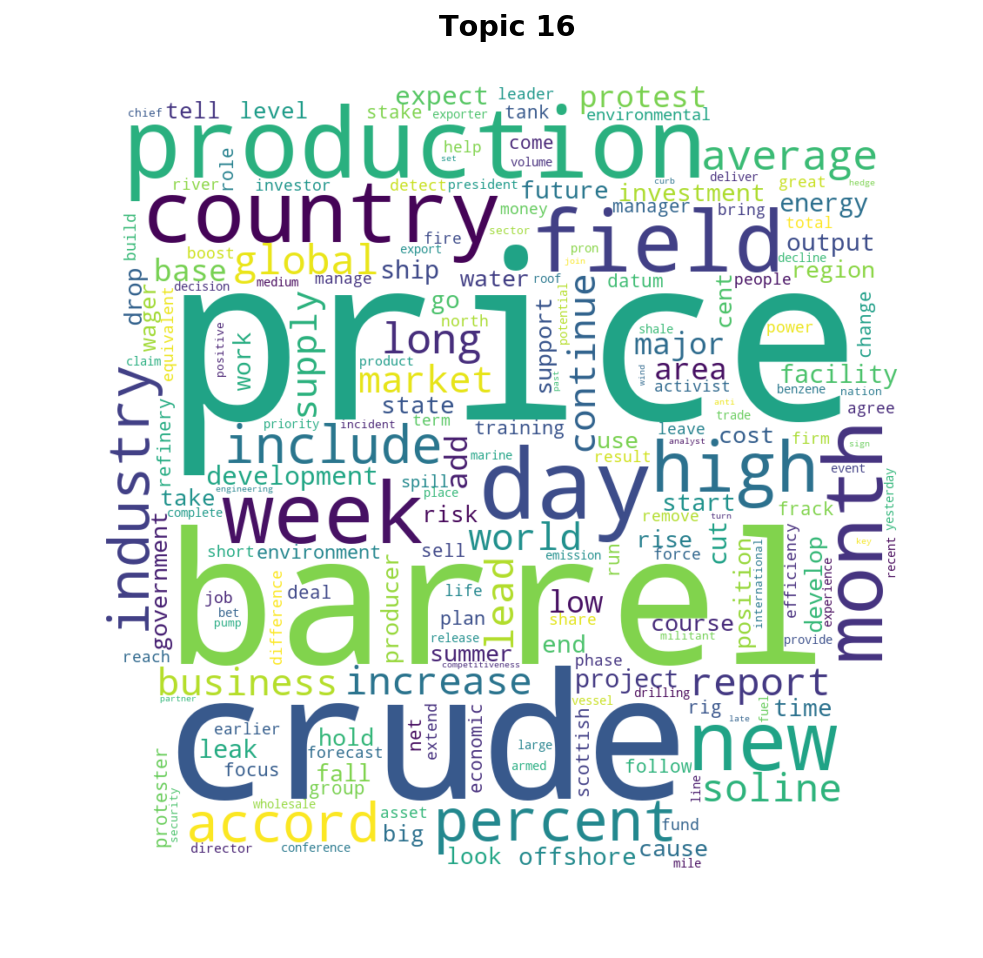

time: 1.55 s


In [51]:
fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(wc16, interpolation='bilinear')
ax.axis("off")
ax.set_title('Topic 16', fontweight='bold')
plt.show()

In [191]:
strings17 = ''
for top, cont in zip(final_df['lda_topic'], final_df['clean_content']):
    if top==17:
        strings17 += cont
strings17 = strings17.replace('say', '').replace('oil', '').replace('year', '').replace('company', '').replace('ga', '')

In [192]:
wc17 = WordCloud(background_color='white', collocations=False, 
                mask=mask_shape, width=3000, height=1500).generate(strings17)

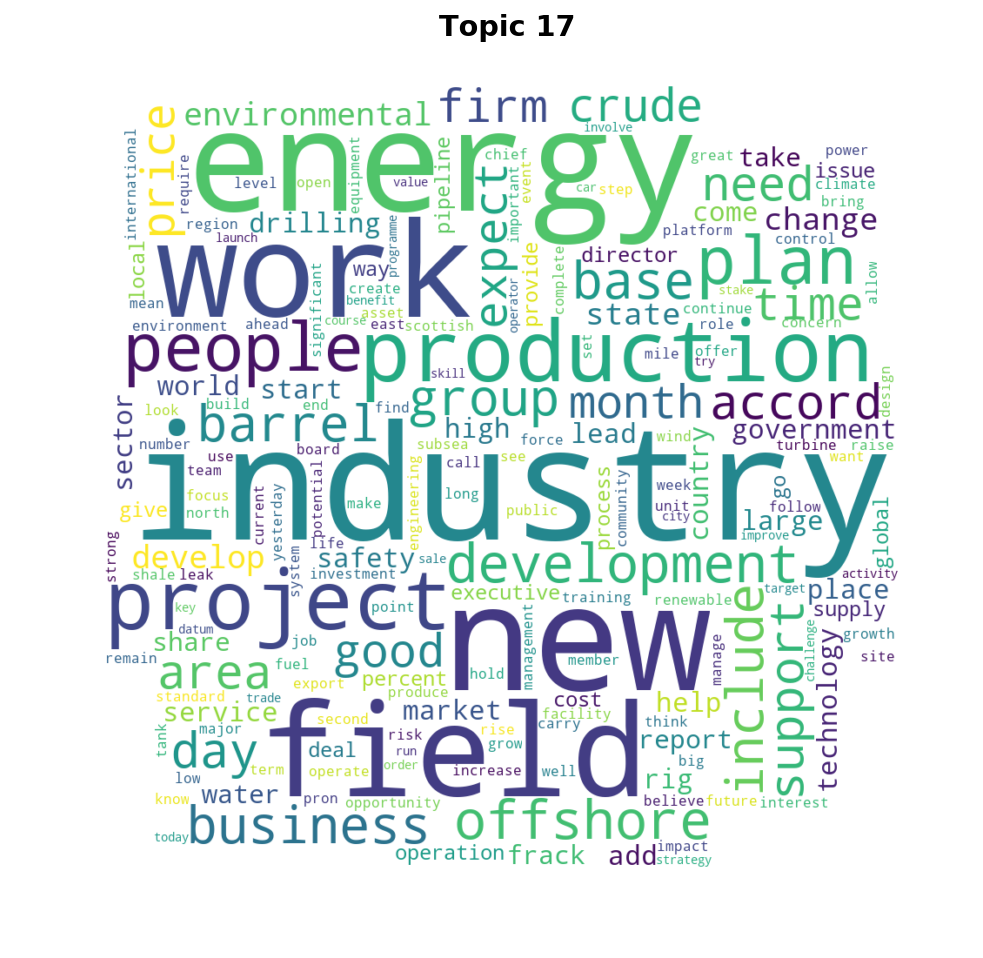

In [202]:
fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(wc17, interpolation='bilinear')
ax.axis("off")
ax.set_title('Topic 17', fontweight='bold')
plt.show()

In [212]:
strings21 = ''
for top, cont in zip(final_df['lda_topic'], final_df['clean_content']):
    if top==21:
        strings21 += cont
strings21 = strings21.replace('say', '').replace('oil', '').replace('year', '').replace('company', '').replace('ga', '')

In [213]:
wc21 = WordCloud(background_color='white', collocations=False, 
                mask=mask_shape, width=3000, height=1500).generate(strings21)

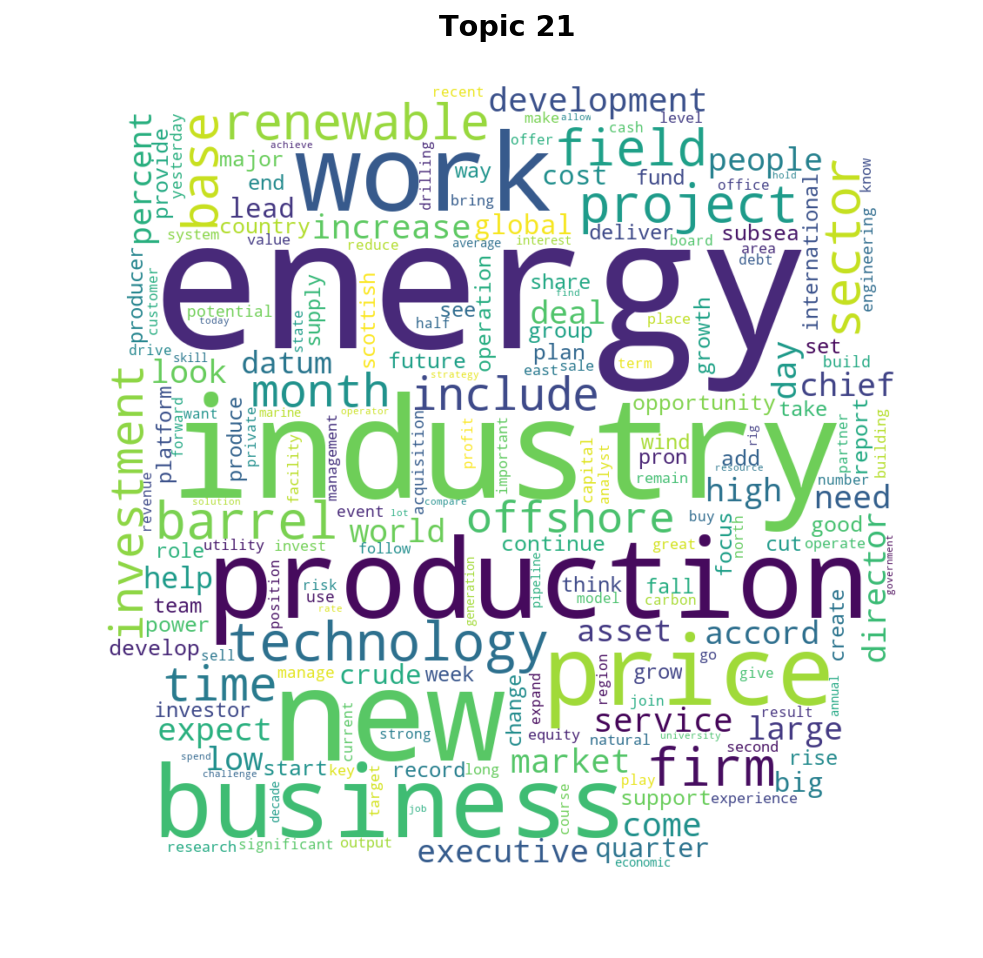

In [214]:
fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(wc21, interpolation='bilinear')
ax.axis("off")
ax.set_title('Topic 21', fontweight='bold')
plt.show()

In [215]:
strings27 = ''
for top, cont in zip(final_df['lda_topic'], final_df['clean_content']):
    if top==27:
        strings27 += cont
strings27 = strings27.replace('say', '').replace('oil', '').replace('year', '').replace('company', '').replace('ga', '')

In [204]:
wc27 = WordCloud(background_color='white', collocations=False, 
                mask=mask_shape, width=3000, height=1500).generate(strings27)

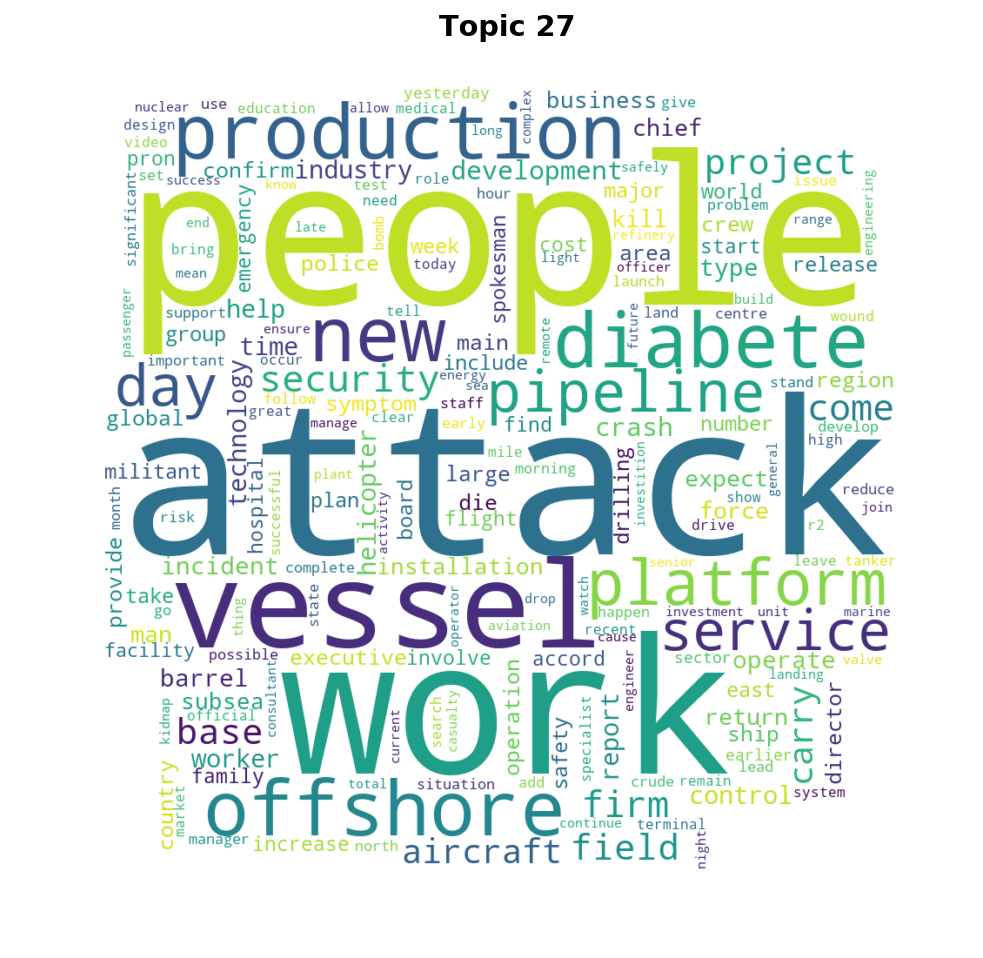

In [205]:
fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(wc27, interpolation='bilinear')
ax.axis("off")
ax.set_title('Topic 27', fontweight='bold')
plt.show()

<a id="rf-eval"></a>

### Random Forest Evaluation

In [64]:
forest_best.predict(X)

array([51.99131938, 46.57298536, 47.28560812, 45.75444263, 46.45807449,
       46.45807449, 46.2693602 , 46.45807449, 46.45807449, 46.28337815,
       46.28337815, 46.28337815, 46.45807449, 46.22613282, 46.22613282,
       46.22613282, 46.22613282, 46.22613282, 46.22613282, 44.97911913,
       46.22619728, 45.75444263, 45.75444263, 45.75444263, 44.61662317,
       35.38405648, 42.76230277, 42.11007566, 37.56211029, 35.59541014,
       36.3503077 , 42.06995671, 44.37408619, 46.68724175, 45.57974629,
       46.22613282, 46.22613282, 45.75444263, 46.22613282, 47.34275496,
       47.34275496, 47.85044777, 47.85044777, 47.34275496, 47.34275496,
       47.84024382, 48.07424087, 47.68619889, 48.06801934, 47.09346491,
       47.34275496, 47.85044777, 47.68619889, 48.37655842, 48.37655842,
       48.37655842, 48.37655842, 48.37655842, 48.37655842, 48.37655842,
       48.37655842, 48.06801934, 48.05135458, 47.53944019, 47.85044777,
       48.51095031, 50.90575369, 46.35652217, 45.10679704, 43.09

In [103]:
from sklearn.metrics import mean_squared_error

In [104]:
mean_squared_error(y_vs_yhat['Actual y'], y_vs_yhat['Predicted y'])

19.92759502511616

In [102]:
forest_best.score(X, y)

0.7964259957706341

In [ ]:
forest_best.score(X, y, )

In [68]:
y_vs_yhat = pd.DataFrame(y)
y_vs_yhat['yhat'] = forest_best.predict(X)
y_vs_yhat.columns = ['Actual y', 'Predicted y']

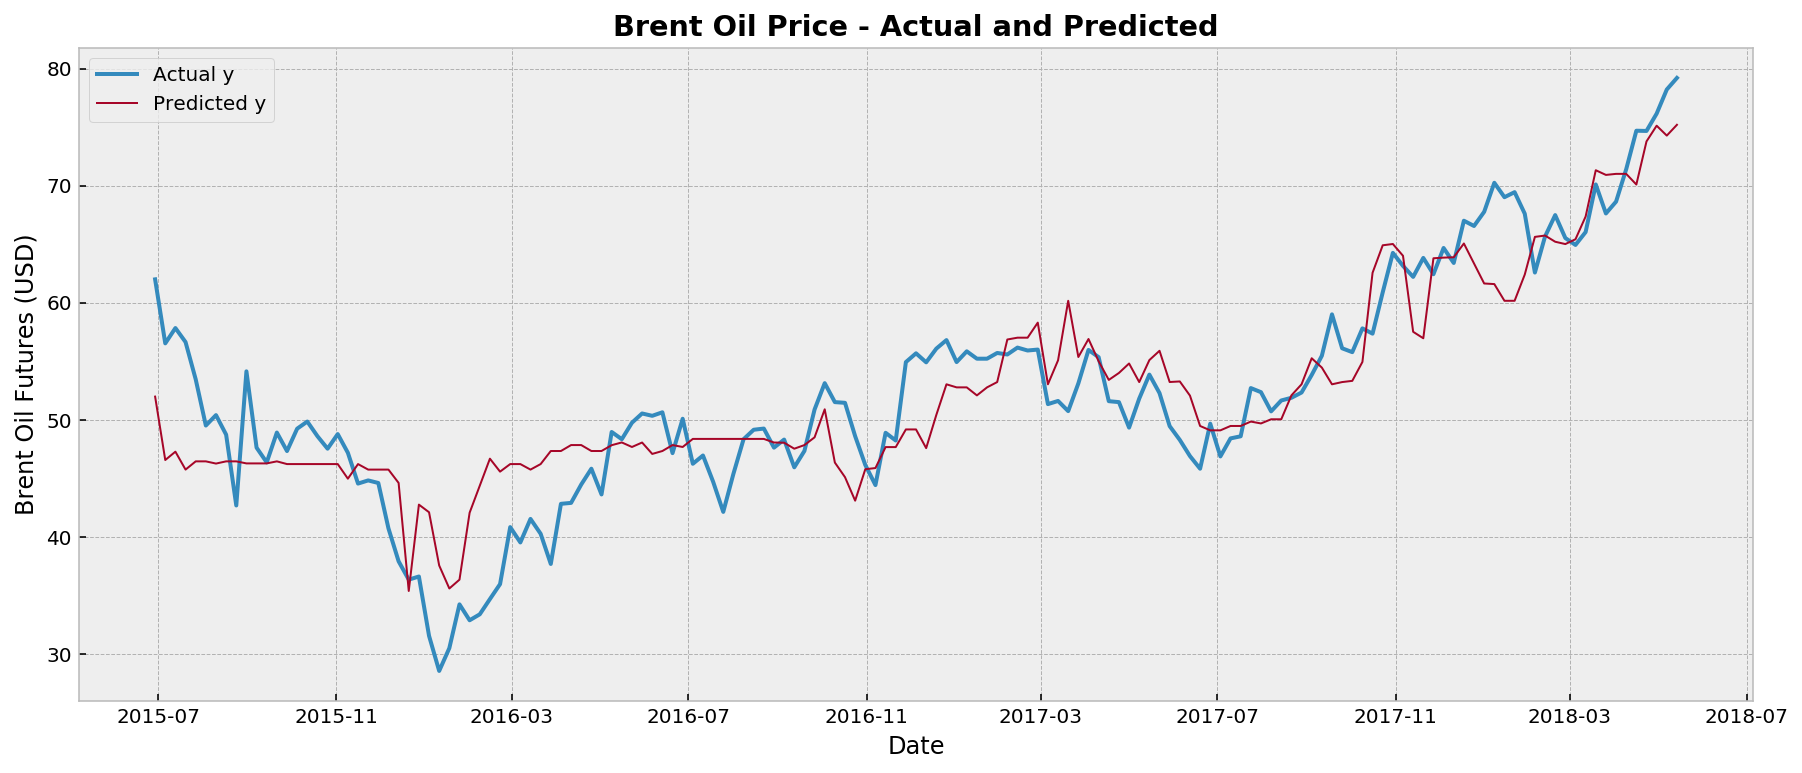

In [100]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(y_vs_yhat.index, y_vs_yhat['Actual y'])
ax.plot(y_vs_yhat.index, y_vs_yhat['Predicted y'], lw=1)
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Brent Oil Futures (USD)')
ax.set_title('Brent Oil Price - Actual and Predicted', fontweight='bold')
plt.savefig('/Users/angusfranz/Desktop/oil_price_predict.jpg', dpi=300)
plt.show()

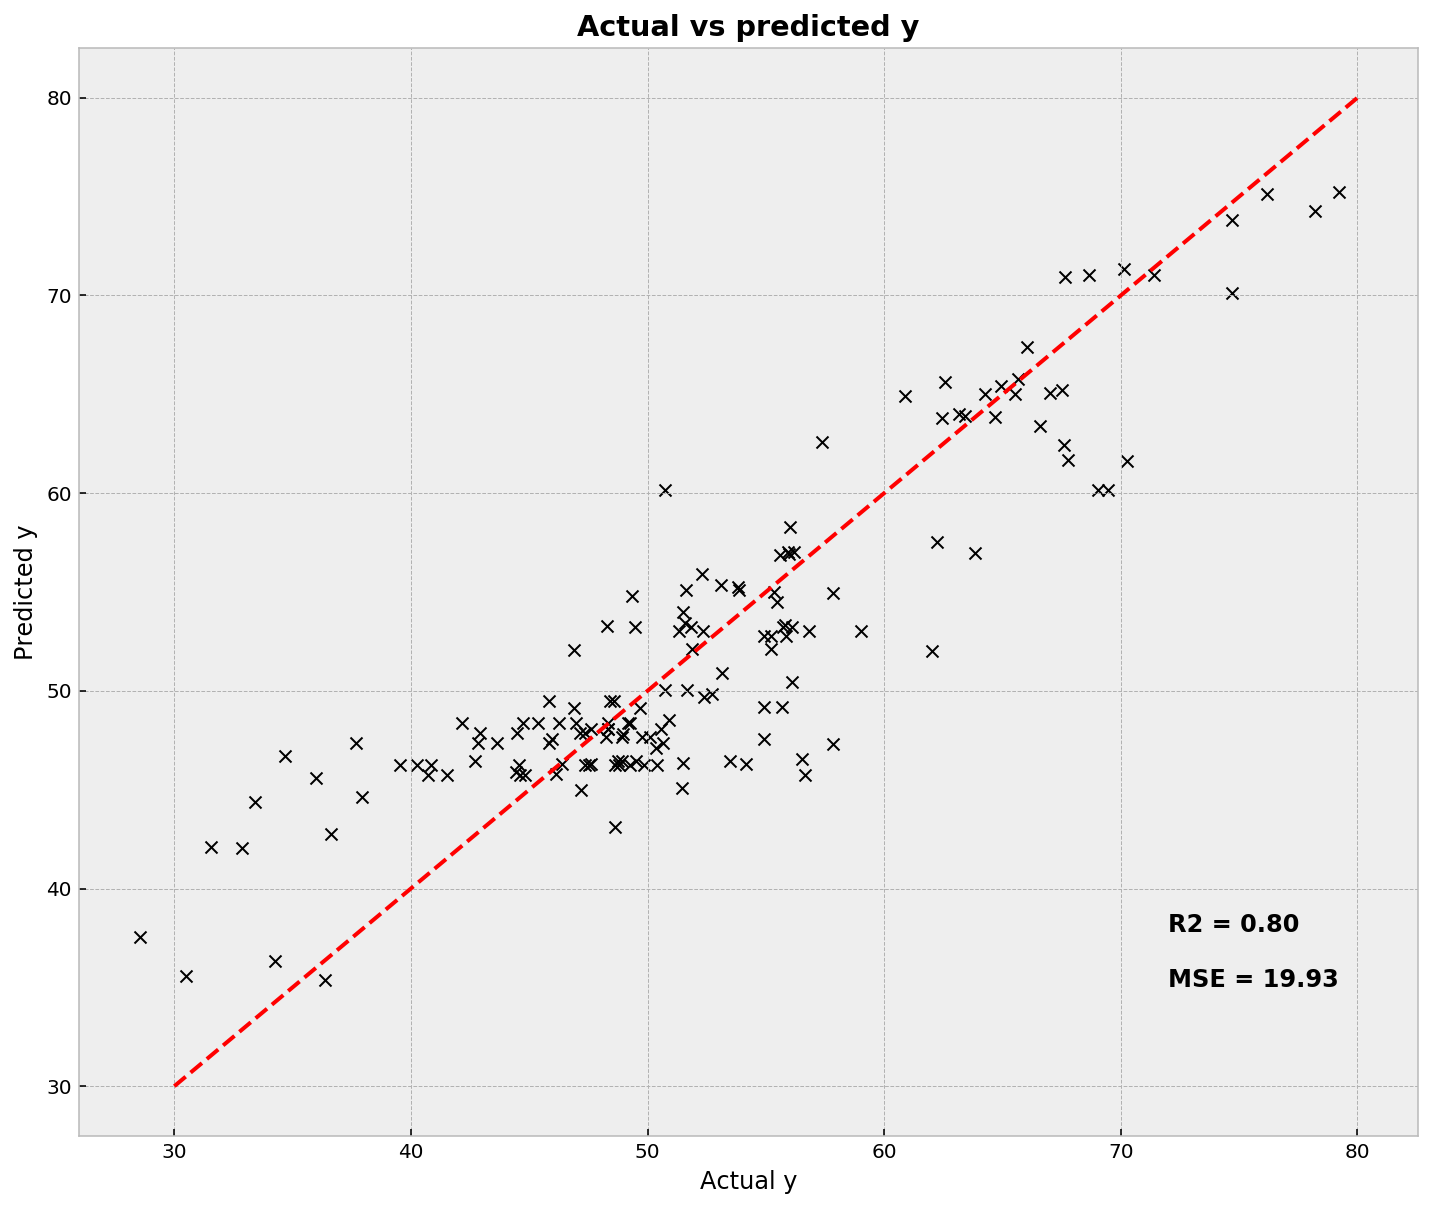

In [115]:
fig, ax = plt.subplots(figsize=(12,10))
ax.scatter(y_vs_yhat['Actual y'],y_vs_yhat['Predicted y'], lw=1, c='black', marker='x')
ax.plot((30,80), (30,80), 'r--')
ax.set_xlabel('Actual y')
ax.set_ylabel('Predicted y')
ax.set_title('Actual vs predicted y', fontweight='bold')
ax.annotate('R2 = 0.80\n\nMSE = 19.93', xy=(72,35), fontsize=12, fontweight='bold')
plt.savefig('/Users/angusfranz/Desktop/y_vs_yhat.jpg', dpi=300)
plt.show()